In [ ]:
import sys
rex_path = "/home/r2ci/rex"
if rex_path not in sys.path:
    sys.path.append(rex_path)
print(sys.path)

In [2]:
import time
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import jumpy
import jumpy.numpy as jp
import jax
import jax.numpy as jnp
import jax.random as rnd
from jax.tree_util import tree_map

import rex.utils as utils
import rex.open_colors as oc
from rex.wrappers import GymWrapper, AutoResetWrapper, VecGymWrapper
from rex.proto import log_pb2
from rex.node import Node
from rex.agent import Agent
from rex.constants import LATEST, BUFFER, SILENT, DEBUG, INFO, WARN, SYNC, ASYNC, REAL_TIME, FAST_AS_POSSIBLE, FREQUENCY, PHASE, SIMULATED, WALL_CLOCK, VECTORIZED
from rex.distributions import Gaussian, GMM
from rex.base import GraphState, StepState
from scripts.dummy import DummyNode, DummyAgent

utils.set_log_level(WARN)

In [3]:
import experiments as exp
import stable_baselines3 as sb3
import envs.double_pendulum as dpend

# Environment
ENV = "double_pendulum"
DIST_FILE = f"21eps_pretrained_sbx_sac_gmms_2comps.pkl"
JITTER = BUFFER
SCHEDULING = PHASE
MAX_STEPS = 5*80
WIN_ACTION = 2
WIN_OBS = 3
BLOCKING = True
ADVANCE = False
ENV_FN = dpend.ode.build_double_pendulum
ENV_CLS = dpend.env.DoublePendulumEnv
CLOCK = SIMULATED
RTF = REAL_TIME
RATE_ESTIMATOR = 40
RATES = dict(world=150, agent=80, actuator=80, sensor=80, render=20)
DELAY_FN = lambda d: d.high*0.75
USE_DELAYS = True   # todo: TOGGLE WITH/WITHOUT DELAYS HERE

# Load models
MODEL_CLS = sb3.SAC  # sbx.SAC
MODEL_MODULE = dpend.models
MODEL_PRELOAD = "sb_sac_model"

# Training
SEED = 0
NUM_ENVS = 10
SAVE_FREQ = 40_000
NSTEPS = 200_000
NUM_EVAL_PRE = 1
NUM_EVAL_POST = 20
HYPERPARAMS = {"learning_rate": 0.01}
CONTINUE = True

# Record settings
RECORD_SETTINGS = {"agent": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "world": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "actuator": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "sensor": dict(node=True, outputs=True, rngs=True, states=True, params=True, step_states=True),
                   "render": dict(node=True, outputs=False, rngs=True, states=True, params=True, step_states=True)}

In [4]:
# Load distributions
delays_sim = exp.load_distributions(DIST_FILE)

# Prepare environment
env = exp.make_env(delays_sim, DELAY_FN, RATES, blocking=BLOCKING, advance=ADVANCE, win_action=WIN_ACTION, win_obs=WIN_OBS,
                   scheduling=SCHEDULING, jitter=JITTER,
                   env_fn=ENV_FN, env_cls=ENV_CLS, name=ENV, eval_env=True, clock=CLOCK, real_time_factor=RTF,
                   max_steps=MAX_STEPS, use_delays=USE_DELAYS)
gym_env = GymWrapper(env)

# Load model
model = exp.load_model(MODEL_PRELOAD, MODEL_CLS, env=gym_env, seed=SEED, module=MODEL_MODULE)

# Make policy
policy = exp.make_policy(model)
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABFcAAAGVCAYAAAA7Rh7lAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAACRyUlEQVR4nOzdd3hb5dkG8Ptoy7Jsee8dJ8509t4kjEDYYUPZFGgLFD4otBRKoWwKZe/RsvdKGIHshOx4xBke8d5DtixZ+3x/yFGieMdDlnz/rsuXdc55z6vnyK9k6dE7BFEURRARERERERER0UmReDsAIiIiIiIiIiJfxuQKEREREREREVE/MLlCRERERERERNQPTK4QEREREREREfUDkytERERERERERP3A5AoRERERERERUT8wuUJERERERERE1A9MrhARERERERER9QOTK0RERERERERE/SDrbUFRFOF0OgczFj8nQCIR4HSKAERvB0PUDf9sqzW1tbDb7d4Ow2tkMhmiIiO9HcYA8s92Sv6IbZV8BdsqDT8SiQSCIHg7DKJe6XVyxel0okFvGMxY/JpMKkWoTotmQyvsDoe3wyHqkr+21fMuvAR1dXUQBAEBAQHeDmfImEwmiKKIiIgIfPvN194OZ8D4azsl/8O2Sr6CbZWGozCdFlKp1NthEPVKr5MrRET+ICAgAJddda23wxgyH7z3FoxGo7fDICIiIiLya5xzhYiIiIiIiIioH5hcISIiIiIiIiLqByZXiIiIiIiIiIj6gckVIiIiIiIiIqJ+YHKFiIiIiIiIiKgfmFwhIiIiIiIiIuoHJleIiIiIiIiIiPqByRUiIiIiIiIion5gcoWIiIiIiIiIqB+YXCEiIiIiIiIi6gcmV4iIiIiIiIiI+oHJFSIiIiIiIiKifmByhYiIiIiIiIioH5hcISLykheeehhF+Ye8HQYREREREfUTkytERERERERERP3A5AoRUTccDoe3Q+jScI6NiIiIiGgkkXk7ACKi4eSLj95DWHgkJBIJDh3IQVh4JBYuPQ1bNvyCqopSyOQKJCanYP7iU6EOCHCfEx4RBalMhrycvZBKpBifORWz5i1y16tvasSvP36LmqpKBAWHYMHSUzvct6GlGVvWr0VpSREEQUBsXCIWLD0VQcE6AMDaNd/AYjEjKjoW2Xt3QSqV4nc3/nFIHhciIiIiIuoae64QEZ3g4P5sSKRSXHDp1ZizcCm++uR/iIiKwkVXXIezL7gUJqMRP3z7eYdz5HI5Vl1+LeYuOgU7t21CaXERAEAURaz++lNIJFKsuvxaLF5+BrZt/NXjfIfDgW8++xByhQLnX/I7XHDp1ZAr5Pjm8w89eqiUlxSjqbEB56y6HGedf8ngPxhERERERNQjJleIiE6gCwnFvEWnICQ0DGXFRQiPisacBUsREhaOiKhonHL6SlSUlaCpscF9TlhEJGbOXQhdSCgyxk9CZHQsykuLAQBlJUXQNzZg2YpzEB4ZhbiEJMxesMTjPgsO5UGEiKWnnYXwiEiEhoXjlNPPRmtLMyrKit3l5HI5lp52FsLCIxAWHjEUDwcREREREfWAw4KIiE4QERXtvl1fV4uK0mK8+tzjHcq16JsQEhoGAAiPiPQ4ptEEos1kBAA0NTQgUBuEwECt+3h0bJxH+fraGjQ3NeK1/zzhsd9ut6NZr3dvh0VEQiqVntyFERERERHRoGByhYjoBHK5wn3bZrUiOW005i5c2qGcRhPovi2RnJDwEFzDgXrLZrMiMioGy888t8Oxo3O7AIBMLu91nURERERENDSYXCEi6kZEVDQK8w8iKFgHieTkRlKGhIWh1dACY6sBmvbeK9WVFR3uJ/9QHgICNFAolf2Om4iIiIiIhg7nXCEi6sbEKdNhaWvDj999iZqqSjTrG1FypBBr13wDp9PZqzoSklKhCwnF2jXfoL62BpXlpfht83qPMqPHToRKHYDvv/oEleWlaNE3oby0GBt/+RGthpZBuDIiIiIiIhoo7LlCRNSNwEAtLrjsamzd+Au++ewDOBx2aIOCkZiSBkEQelWHIAg445xV+PXH7/DJ+28hKCgYC5aehm8//9BdRi6X4/xLrsLWDb9g9defwWa1QBOoRXxSChQK9mQhIiIiIhrOBLGXkwI4HA406A2DHY/fkkmlCNVp0ag3wH7csqpEw42/ttWVZ5+Duro6aDQaXHbVtd4OZ8h88N5bMBqNiIiIwLfffO3tcAaMv7ZT8j9sq+Qr2FZpOArTaTmRP/kMDgsiIiIiIiIiIuoHJleIiIiIiIiIiPqhD3OuCJCxS9ZJk0olHr+Jhit/bau9nB7FbwkC/Oo13F/bKfkftlXyFWyrNDyN8Ddw5FN6nVyRSASE6rSDGcuIEKzVeDsEol7xt7YqEUb2m0WJIPHL13B/a6fkv9hWyVewrRIRnZxeJ1ecThHNhtbBjMWvSaUSBGs1aDYY4XD0bvlWIm/w17bqFP3nWk6GU3Si0Y8mJffXdkr+h22VfAXbKg1HwVoNe1ORz+jDsCCRM4cPAIfDyceRfIK/tdXu1kXbtX0Lig4fRFNjA2QyGaLj4jF34SkICQ1zl7Hb7diy/mccPpgHp8OOhOQ0LF52OgI0gd3cp4gdWzZgf84+WCxmxMTGY/HyFdCFhHZ5zto138BiMePMcy/y2F9eWoyvPvkfbvjDXVCqVL2/cHcs8Ku/51H+1k7Jf7Gtkq9gW6XhpVcL2xINC0wDEtGIV1lWgolTpuPCy6/BOasuh9PhxDefvg+b1eous3ndTzhSmI8zzj4f5118FYytBqz++rNu692zYxuy9u7E4uVnYNXl10AuV+Cbzz6A3W4f7EsiIiIiIqIh1IeeK0RE/unsCy/z2F52xkq8+dK/UVtThbiEJFgsZuTl7MOpZ56H+MQUV5nTV+L9t19BdWU5omPjO9QpiiKy9uzA9NnzkTpqjOucFWfjrZf+jaKCQxidMb5fMX/x0XuoLC/tsP+qG/6AoGBdv+omIiIiIqK+YXKFiOgEFosFAKBSqQEAdTVVcDqdSEhKcZcJCQuHVhuE6sqKTpMrLc16mIytHucolSpExcShurK838mVFeesgsN5rNv2hrU/oLGhDgEBnIiQiIiIiGioMblCRHQcURSxad1PiImLR1hEJADAaDRCIpV2mOtErQmEydj5RN9H95+Y7AgI0MBkNHYbQ3FhPl597nGPfc4TJo1RqdXu2/t2bUdFaTEuvPwayOTybusmIiIiIqKBx+QKEdFxNqxdg8b6Olxw6e+8FkN8YjIWLTvDY19NVQV+Xv11h7IlRQXYuulXnHXeRR4T8BIRERER0dBhcoWIqN2GtT+guCgf5198FQK1Qe79Go0GTocDFrPZo/dKm7G1y9WCju43mYzQBGrd+00mI8Ijo7qNQyaXd1hRqNXQ0qFcY30dfvzuS8xdsBSJyWk9XyAREREREQ0KrhZERCOeKIrYsPYHFBUcwrkXXYkgXYjH8YioGEgkEpSVHnHva2psgMHQgujYuE7rDArWIUATiPKSYvc+q8WCmqrO52jpqzaTCd99+THSRmdg8vRZ/a6PiIiIiIhOHnuuENGIt2HtDzh8MBdnnnsR5AoFjO3zpSgVSsjkciiVKoybOBlb1v0MlUoNhUKJjb/+iOjYeI9Eyf/eehlzFixBWnoGBEFA5tSZ2PXbZuhCQqEN1mH7lvXQBGrdqwf1x5pvPoNMLsfMuQvd8QKAWh0AiYR5cyIiIiKiocTkChGNeLlZuwEAX378X4/9p5y+EmMnZAIA5i85FYIgYM03n8FhdyAxJbXDvCj6xgZY21caAoCpM+fAbrNi3U/fw2IxIyYuASsvuBQyWf9feo8uw/zua8977OdSzEREREREQ08QxROWoOiCw+FAg94w2PH4LZlUilCdFo16A+wOR88nEHmJv7bVlWefg7q6Omg0Glx21bXeDmfIfPDeWzAajYiIiMC333ScENdX+Ws7Jf/Dtkq+gm2VhqMwnRZSqdTbYRD1CvuOExERERERERH1A5MrRERERERERET9wOQKEREREREREVE/MLlCRERERERERNQPTK4QEREREREREfUDkytERERERERERP3A5AoRERERERERUT8wuUJERERERERE1A9MrhARERERERER9QOTK0RERERERERE/cDkChERERERERFRPzC5QkRERERERETUD0yuEBERERERERH1A5MrRERERERERET9wOQKEREREREREVE/MLlCRERERERERNQPTK4QEREREREREfWDzNsBEBENJZPJhA/ee8vbYQwZk8nk7RCIiIiIiPwekytENCIEBAQAAERRhNFo9HI0Q+/o9RMRERER0cBjcoWIRoSbbrwBr772+rDuySGKIurr693bKpUKWq223/UGBATgphtv6Hc9RERERETUOSZXiGhEWLp0KZYuXertMLr15ltv4/XXX3dvm81m3H7bn3Duued6LygiIiIiIuoRJ7QlIhomamtqOux7/IknsXr1Gi9EQ0REREREvcXkChHRMGFoNXTYJ4oiHn7kEfy8dq0XIiIiIiIiot5gcoWIaJgoLi7udL/T6cSDD/4DmzdvGdqAiIiIiIioV5hcISIaBux2O0pLy7o87nA48ORTT8Fmsw1hVERERERE1BtMrhARDQOVlZWw2+3dljl+JSEiIiIiIho+mFwhIhoGqqqqeixzycUXQy6XD0E0RERERETUF1yKmYhoGIiKiuryWGBgIN54/TUkJSUNYURERERERNRb7LlCRDQMJCcn46677kRycjKmTZ3qcay1tRVtbW0QBMFL0RERERERUXeYXCEiGiYuvOACfPThB3jxxReQlJjocWzHjp1eioqIiIiIiHrC5AoR0TA0Y+ZMj+3tO3Z4KRIiIiIiIupJH+ZcESCTSgcvEj8nlUo8fhMNV2yrw8PcObPx2Wefubezs7NhtVgQEBDgxaiGD7ZT8hVsq+Qr2FZpeOKQaPIdgiiKYm8KiqLI8f5EREOktdWIqTPneCzP/PUXn2LihPFejIqIiIiIiDrT654rTqeIZkPrYMbi16RSCYK1GjQbjHA4nN4Oh6hLbKvDx+JFi7D2l18AAEqlEgqlGo16g5ejGh7YTslXsK2Sr2BbpeEoWKthbyryGX0YFiTC7nAMXiQjhMPh5ONIPoFt1fvuuON2KJRKVFdX45JLLkZIaCj/JidgOyVfwbZKvoJtlYaXXg2yIBoW+pBcISKioRQWFoa/3/83b4dBREREREQ9YB8rIiIiIiIiIqJ+YM8VIqJhLjc3F6+9/jqkUhluufn3SE9P93ZIRERERER0HCZXiIiGMVEUcfc9f0FjYyMAoLKyEh+8/z9IpVIvR0ZEREREREdxWBAR0TBms9nciRUAKCkpQX5BgRcjIiIiIiKiEzG5QkQ0jCkUCiQkJHjsy8rK8lI0RERERETUGSZXiIiGucxJkzy2s7NzvBQJERERERF1hskVIqJhbtKJyZWsLIii6KVoiIiIiIjoREyuEBENc5mZnsmVuvp6VFVXeykaIiIiIiI6EZMrRETDXGJiInQ6nce+7Oxs7wRDREREREQdMLlCRDTMCYKAiRMneOzLymJyhYiIiIhouGByhYjIB2ROyvTYZs8VIiIiIqLhg8kVIiIfcOKktkVFRTAYDF6KhoiIiIiIjsfkChGRD8jIGAOFQuHeFkURObm5XoyIiIiIiIiOYnKFiMgHKBQKjB071mNfVlaWl6IhIiIiIqLjMblCROQjJk2a6LGdnZ3jpUiIiIiIiOh4TK4QEfmIEye1zdu/HzabzUvREBERERHRUUyuEBH5iIkTPXuuWKxWFBQUeCkaIiIiIiI6iskVIiIfERwchISEBI99h/PzvRQNEREREREdxeQKEZEPmTB+vMe2VCr1UiRERERERHQUkytERD7kqquuRGBgIAAgISEBc+fM8XJEREREREQk83YARETUeykpKfj6qy9RVFSEUaNGQa1WezskIiIiIqIRj8kVIiIfo9FoOkxuS0RERERE3sNhQUREPshisWD//jw0Nzd7OxQiIiIiohGPPVeIiHyM0WjELbf+AYcOHYJKpcJzzz6LzMxJ3g6LiIiIiGjEYs8VIiIfs2/fPhw6dAgAYDab8fY773g3ICIiIiKiEY7JFSIiH+NwODy29+/fD1EUvRQNERERERExuUJE5GNGpad7bBsMBlRVV3spGiIiIiIiYnKFiMjHxERHI0ir9dh3+NBhL0VDRERERERMrhAR+RhBEJA+2rP3yuHDTK4QEREREXkLkytERD5o9OjRHtuFhYVeioSIiIiIiJhcISLyQakpqR7bJaWlXoqEiIiIiIiYXCEi8kGJiYke2+Xl5bDb7V6KhoiIiIhoZGNyhYjIByUmJnhs2+12VFVxxSAiIiIiIm9gcoWIyAfpdLoOKwaVlXFoEBERERGRNzC5QkTkgwRBQGKS59CgkhImV4iIiIiIvIHJFSIiH5WYmOSxXcpJbYmIiIiIvILJFSIiH5V0wqS2XDGIiIiIiMg7mFwhIvJRJw4LYs8VIiIiIiLvYHKFiMhHndhzpb6+Hkaj0UvREBERERGNXEyuEBH5qPj4eEgkni/jlZWVXoqGiIiIiGjkkvW+qACZVDp4kfg5qVTi8ZtouGJb9R0ytRrjx41DTm6ue19kRMSIeK1mOyVfwbZKvoJtlYYnwdsBEPWaIIqi2JuCoihCENi4iYiGkz179+HO/7sHjU16/OGWm3DDddd6OyQiIiIiohGn18kVh8OJZgPH8p8sqVSCYK0GzQYjHA6nt8Mh6hLbqu9xOp0QBGFEJcDZTslXsK2Sr2BbpeEoWKthbyryGX0YFiTC7nAMXiQjhMPh5ONIPoFt1cf0Lk/ud9hOyVewrZKvYFul4WVkvr8h39SH5AoREQ1HdrsdGzZshCiKWLJkMaQjYM4VIiIiIqLhhMkVIiIf9+A//oG1a38BACxfvgz/fOghL0dERERERDSycAAbEZEPs9lsWL9+g3t77dpf0Nzc7MWIiIiIiIhGHiZXiIh8mCAIcDqPTTwoiiKqqqu9GBERERER0cjD5AoRkQ+TyWQIDw/32FdbU+OlaIiIiIiIRiYmV4iIfFxkZITHdk1NrZciISIiIiIamZhcISLycVGRUR7btXVMrhARERERDSUmV4iIfFxkVKTHNnuuEBERERENLSZXiIh8XGSEZ3KltpZzrhARERERDSUmV4iIfFxU1InJlTovRUJERERENDIxuUJE5OMiI09MrtR6LM9MRERERESDi8kVIiIfFxHhuVqQ3W6HwWDwUjRERERERCMPkytERD4uOFjXYV9zS8vQB0JERERENEIxuUJE5ONUKiWUCoXHvhYmV4iIiIiIhgyTK0REfiAoONhju6W52UuREBERERGNPEyuEBH5gaCgII9tDgsiIiIiIho6TK4QEfmBYPZcISIiIiLyGiZXiIj8wIk9V1q4WhARERER0ZBhcoWIyA+MGzfWYzsxIdFLkRARERERjTxMrhAR+YFzzzkHCxcuQJBWizNOPx2LFy/ydkhERERERCOGzNsBEBFR/wUFBeGJxx/3dhhERERERCMSe64QEREREREREfUDkytERH7CYrFgzQ8/YP36DRBF0dvhEBERERGNGBwWRETkJ26/48/Yu3cvAOCii1bhz3fc4eWIiIiIiIhGBvZcISLyA7W1te7ECgB899337L1CRERERDREmFwhIvIDZrPZY9tkMsFut3spGiIiIiKikYXJFSIiP6BUKjvss1qtXoiEiIiIiGjkYXKFiMgPKBSKDvvMFosXIiEiIiIiGnmYXCEi8gOdJVesTK4QEREREQ0JJleIiPwAhwUREREREXkPkytERH5AJpNBKpV67LOw5woRERER0ZCQeTsAIiIaGAqFAm1tbe5t9lwhIiKikcLhcMBms3k7DPIjcrm8w5eX3WFyhYjITyiVSo/kioXJFSIiIvJzoiiiqqoKer0eoujtaMifCAKg0+kQExMDQRB6LM/kChGRnzhxUlsOCyIiIiJ/V1VVhaYmPbRaXfscdD1/CCbqmQiLxYKmJj0AIDY2tsczmFwhIvITJyZXrBb2XCEiIiL/5XA4oNe7EitabbC3wyE/o1CoAAB6vR5RUVE9DhHihLZERH7ixBWD2HOFiIiI/JnNZoModr5qItFAUCqVEEX0aj4fJleIiPyE8sSeK5xzhYiIiEYEDgWiwdL7tsXkChGRn5DKPEd62u12L0VCRERERDSyMLlCROQnRNHpsS2R8iWeiIiIyBc89NADuOyyVd2WOffcM/HUU48N+H3ffPMNuPPOP3nlvv0JJ7QlIvITTqfn+oMCu8gSERER0QB4/PGnodUGeTuMYY1faxIR+Ynk5GSP7ZSU5E7LERERERH1xZgxGb1ajngk60PPFQGyHpYeoq5J27vnS9lNn4Y5tlXfde01V+PggQMoLinB+eedh8xJkyCR+Offke2UfAXbKvkKtlUankZeL9ytW7fghReeRXl5GVJSUvF///cXTJgwqcvy69b9grfeeh0lJcUICgrCsmWn4eab/+CxgpLBYMCrr76EDRvWQa9vQnh4BJYvPw233PLHTus0m8247767UVx8BM8//zLi4uJx7rlnYv78Bbjrrr8AcA1jOngwD3feeQ+ee+5plJaWIDU1DXfffS8yMsa562ptNeDJJx/Dpk0boFQqcfbZ5yIoSIfnn/83fvttzwA9asNDr5MrEomAUJ12MGMZEYK1Gm+HQNQrbKu+J1Q3AWt//N7bYQwptlPyFWyr5CvYVom8p76+Hk8++Siuv/4maLVB+O9/38Ztt/0Bn376FUJDQzuU37hxA+677253oqSkpBgvv/wiamqq8eijTwJwrR556603obq6EtdddyPS0kahpqYGWVn7Oo3BZDLhrrtuR0NDPV555U1ERkZ2GW9DQwOeeeYJXHXVNQgMDMRLLz2Pe+65C59//jVkMjkA4J//fBC7d+/ErbfehpiYGHz99Zc4ePBA/x+sYajXyRWnU0SzoXUwY/FrUqkEwVoNmg1GOBzOnk8g8hK2VfIFbKfkK9hWyVewrdJwFKzVnFRvKlEUYTabByGinqlUKgjCyfW4aWlpxr/+9TimT58JAJg6dSrOPnsFPvro/U57mbzxxquYMGEiHnroXwCAOXPmQaVS4bHHHkFBQT5GjUrH6tXf4fDhg3j99bcxcWKm+9wzz1zZyf234I47/gCr1YqXX36j04TOifG+/PLrSE1Na792NW699Ubk5uZi8uQpOHKkCBs2rMMDDzyEM844CwAwe/ZcXHzx+Sf1+Ax3fRgWJMLucAxeJCOEw+Hk40g+gW3VNx0+fBjV1dWYMWMG1Gq1t8MZdGyn5CvYVslXsK3S8CL2XOTEM0QR1914PbKyswchnp5lTsrEm6+9flIJlsDAQHdixbWtxYwZM7F/f06HsiaTCfn5h/DHP97hsX/ZslPx2GOPICtrH0aNSseuXTuQnJzikVjpjF6vx6233giFQoEXX3wNQUE9T14bHh7hTqwAQEpKKgCgrq4WAJCXtx8AsGDBIncZiUSC+fMX4sMP/9dj/b6GqwUREfmJNT/8gH/+82E4nU6kpKTgvXffgVwu93ZYREREREPMN+dq0elCOuwLDQ1DcfGRDvtbWw0QRbFD75LAQC0UCgVaWpoBAM3NzQgPj+jxvsvKStt7rtzVq8QKAGi1ntOGHH3fabFYAAANDfWQyWQIDPQsFxLSfY8YX8XkChGRn/jqq6/hdLq6ch85cgT79mVhxozpXo6KiIiIaOgIgoA3X3vdJ4cF6fVNHfY1NjYgPDy8w/7AQC0EQUBTU6PH/tZWA6xWK4KCggEAwcHBKCjI7/G+J06chBkzZuG5555BUFAwzjjjzJO6huOFhYXDbrejtdXgkWA5MWZ/weQKEZGf0Ov1HtsGQ4t3AiEiIiLyIkEQfHJ4dGtrK3bt2uEeGtTaasDOnTtw4YUXdSgbEBCA9PQx+PXXX3DppVe4969d+zMAIDNzMgBgxoxZWLv2J+Tm5mDChInd3v8ll1wOi8WChx9+EEqlEkuXLuvX9Ywd61o1aOPGDVixwjXnitPpxObNG/tV73DF5AoRkb8QPcclC366DDMRERGRPwoKCsYjjzyEG274PQIDtfjvf98GIOLiiy/rtPz119+Ee+75Mx544K84/fQVKC0twcsvv4AlS07BqFHpAIAzzjgTn3/+Ke6887b21YLSUFtbi3379uDee+/vUOfvfnctLBYL/v73+6BQKDB//sKTvp7U1DQsWrQEzzzzBMxmM6KjY/D111/AYrGcdO+e4YzJFSIiP+E8Mbnio+ONiYiIiEai8PBw3Hrrn/D888+ioqIcKSlpePbZFxEWFtZp+YULF+GRR57AW2+9hrvv/jOCgoJx7rnn4+abj60spFAo8MILr+CVV17Eu+++hZaWZkRGRmH58tO6jOPGG2+GxWLGfffdjaeeeg4zZ8466Wv6298exFNPPYbnn/83FAolVqw4C6mpafjss49Pus7hShBFsVdTMDscDjToDYMdj9+SSaUI1WnRqDdwBnYa1thWfde5552P6upq9/ZTTz6J+fPneTGiwcN2Sr6CbZV8BdsqDUdhOi2kUmmXx81mMwoLixAeHg2FQjmEkVF//P7310EikeKll17zdig9slotqK+vRlpaKlQqVbdl2XOFiMhPtLW1eWyrA3xvrDERERER+Y9ff/0FNTVVSEtLh9lsxk8/rcG+fXvx+ONPezu0AcfkChGRnzCfkFwJ8MGJ3IiIiIjIfwQEqLFmzWqUl5fCZrMhKSkZDz74MBYtWuLt0AYckytERH7AbrfDYrV67PPFWfKJiIiIyH/Mnj0Xs2fP9XYYQ4JLSRAR+QGz2dxhH5MrRERERERDg8kVIiI/YDK1ddjH5AoRERER0dBgcoWIyA+YzUyuEBERERF5C5MrRER+wHTCZLZyuRxyudxL0RARERERjSxMrhAR+YE2k8ljW61SeSkSIiIiIqKRh8kVIiI/0HZCzxV1QICXIiEiIiIiGnmYXCEi8gNtbZ6rBXG+FSIiIiKiocPkChGRH2hrO2FYkJrDgoiIiIio915//RUsWTKvx3I333wD7rzzTwN+/w899AAuu2yVV+57IMi8HQAREfVfdHS0x3ZSUpKXIiEiIiIiGhx3330vJJLh2UdkeEZFRER9kpmZiaVLlgAAYmNjccXlV3g5IiIiIiKigZWSkoqkpGRvh9EpJleIiPyAXC7HI488jF/W/oyPPvwAo0aleTskIiIiIuqlo0Nidu/ehauuuhSLF8/FtddeiYMH89xlLBYLnn32aZx11qlYuHA2rrzyEqxf/2uf6+lJXt5+XHvtlVi4cDYuvvh8bN68scdz9u7djRtuuBqLFs3BaactxcMPP4jm5maPMlarFa+88iLOP38lFiyYhZUrT8dDDz3QZZ1OpxOPPPIQTjttKQ4ccMV/4rCgo0OZCgryceON12LRorm47LJV+O23rR512Ww2PP30Ezj11MVYtmwhHnvsYfz44xrMnj0VlZWVvX5susPkChGRnxAEARqNBgqFwtuhEBEREVEfNTQ04JlnnsDll1+FRx55HBaLBffccxfsdhsA4IEH/oqvvvocV1zxOzz++NNISUnFvff+HzZu3NCnerpjt9vxt7/9BStWnIXHHnsK8fEJuOeeu1BQkN/lOQcP5uFPf7oFAQEBeOSRx3HrrX/C5s0bcccdf4TD4XCXu/feu/Dhh+/jrLPOwdNP/wd//OPtMJvbOq3TbrfjgQf+iq1bN+Oll17D2LHjuo35gQf+ijPPXInHH38KISEhuPfe/0Nzs95d5sUX/9P+2F2Nhx9+DE6niJdeer7Hx6MvOOcKEZGfKCwsREtLCyZOnAiZjC/vRERENHK1tXX+oR0AJBIJlEplr8oKggCVSnVSZfuqpaUZL7/8OlJTXT2QVSo1br31RuTm5kKj0WD9+l9xzz334bzzLgQAzJkzD1VVlXjzzVexcOGiXtUzefKUbmOw2Wy45prrsHLluQCAWbPmYNWqc/Huu2/hn/98tNNz3n77TYSFheHpp5+DTCYHAERFReG2227F1q2bsWDBImzf/hu2bNmMhx76F0499XT3ucffPspqteKvf70H+fmH8PLLbyAxMbHHmG+99U+YO3c+ACAxMRnnn38Wtm7dgjPOOBPNzc348svPcM011+Oqq64GAMyePRd/+MPvUVNT3W3dfcF330REfuDzL77AU089DVEUMXv2bPz7machCIK3wyIiIiLyivmLF3Z5bN7cefjPv591by87/VSYzeZOy06bOhWvvfyqe/usc8+GXq/vtOy4sWPx33feO6l4ASA8PMKdEAFc84sAQF1dLQoKXPe5dOlyj3OWLTsVzz77NNra2qBWq3usB3ANt3E6ne7jUqnU433jokVLPY4tXLgYGzeu7zLurKy9WL78dHdiBXAlZbRaLbKy9mHBgkXYtWsHVCoVli8/rdvHwGKx4M47b0N1dRVeeeVNREfHdFsecCXLZsyY5d6OjY2FUqlyX29hYQEsFgsWLFjkcd7ChYuxa9eOHuvvLQ4LIiLyAx988AFEUQQA/Pbbbygvr/ByRERERETUF1qt1mNbLnclKywWC1paDJDJZAgODvYoExoaBlEUYTAYelUPADz88D8wf/5M98/333/rLiuTyRAUFNThPhoa6ruM22AwIDQ0tMP+0NAwtLS0AACam5sRHh7e45d/TU1N2Lt3N+bNm9+rxAoAKJVK9zUeJZfL3Nd7NHadLsSjTEiI53Z/secKEZGPczgcqKry7NLY1fhVIiIiopFg8/quJ2E9cSnftT/81GXZE5MB3331Ta/LDqSgoCDY7Xa0tLR4JD8aGxsgCEKHhEp3rr/+JqxadbF7OzY21n27q/sICwvvNrampqYO+xsbG9z1BAcHo76+HqIodvs4RUdH4/rrb8L999+L4GAdrrnm+l5fV1eOxq7XNyEiIsK9v7OY+4M9V4iIfFxLS4tH105g4DPxRERERL5ErVZ3+XP8fCs9lT1xDpW+lB1ImZmTAQC//vqzx/5fflmL0aPHuIcE9UZsbCzGjh3n/gkO1nkc37Dh2ApEDocDGzeux/jxE7qsb9Kkydi4cR3sdrt73/btv8FgMLjjnjFjFsxmM9au7TqRddTSpctw//3/wOuvv4KPPnq/19fVlbS0NCiVyg5DmzZuXNfvuo/HnitERD6us6y7Tqcb+kCIiIiIaFCkp4/G4sVL8dxzz8BisSAxMQk//LAaOTlZeOKJZwbsfuRyOd5++01YLFbExsbh888/QU1NDR5//Okuz7nmmutwww3X4K67bsOqVZegsbEBL730PMaNm+CeZHbmzFmYO3c+HnnkH6ioKMf48RPQ0tKCX39di0ceebxDnaefvgIWiwWPP/4IlEqlexLfkxEcrMN5512Id955EwqFAqNHj8Evv6xFaWkpAEAiGZgeR0yuEBH5uBOTK0FaLVcLIiIiIvIzDz74MF555QW89947aGlpRlJSMv71ryc6TNTaHzKZDA899C889dRjKCwsQGxsHB599Emkp4/u8pyMjHF47rmX8PLLz+Pee/8PKpUaCxYsxJ/+9GdIpVJ3uUcffRJvvvkavvrqc7zxxqsIDQ3DrFmzu6z3nHPOg9VqwZNPPgalUoUVK8466eu69dY/wW6347333obTKWLRoiW46qqr8dRTjyMwMPCk6z2eIB6dAbEHDocDDXpDzwWpUzKpFKE6LRr1BtiPW+ubaLhhW/U9P69di/vv/7t7OykxER9//JEXIxp8bKfkK9hWyVewrdJwFKbTenw4P5HZbEZhYRHCw6OhUCi7LEfUmQcf/Buysvbhyy+/67KM1WpBfX010tJSexz2xa82iYh8nL5J77Gt43wrRERERERue/bsRnb2PmRkjIXTKWLLlo348cc1uO22Pw/YfTC5QkTk404cFsTJbImIiIiIjgkIUGPLlk3473/fhcViRmxsHG677c+45JLLB+w+mFwhIvJxdXV1HtuhoUyuEBEREREdlZExDq+//s6g3geXYiYi8nFVVVUe29HR0V6KhIiIiIhoZGJyhYjIx1VXV3tsx8TEeCkSIiIiIqKRickVIiIf5nQ6UV1T47Evhj1XiIiIiIiGFJMrREQ+rL6+AXa73WMfe64QEREREQ0tJleIiHzYifOtKBQKrhZERERERDTEmFwhIvJhJ863Eh0dDYmEL+1EREREREOJ78CJiHxYTc2Jk9lyvhUiIiIioqHG5AoRkQ8LDQ312M7IyPBSJEREREQ0GB566AFcdtmqbsvcfPMNuPPOPw1RRNQZmbcDICKik7dkyRL88ONP2LVrF8aNHYuLVnX/j5eIiIiI/M/dd9/LoeFexuQKEZEP02g0eOH5/8BkMkGlUvGfKhEREdEIlJKS6u0QRrw+JFcEyKTSwYvEz0mlEo/fRMMV26pvCtJqvR3CkGI7JV/Btkq+gm2VhifB2wEMmaKiQjz//LPYvz8XFosFUVFRWLnyHFx55dUdyjqdTjz66MPYuHE9nn32BYwdOw4333wDAgLUePrp/wAAXn/9FXzwwX/x4ouv4amnHkNBQT5iYmLxxz/ejvnzFw7x1Y0MvU6uSCQCQnUj6837YAjWarwdAlGvsK36htZWIzZs3Ii0tDRkjBnt7XCGHNsp+Qq2VfIVbKvkD0RRhNlu8cp9q2RKCELfk0J33XU7QkND8de//h2BgYEoKytDXV1Nh3J2ux3/+Mf92LNnN1566TWkpY3qsk673Y6//e0vuOyyKxAbG4fPP/8U99xzF959932MGpXe5xipe71OrjidIpoNrYMZi1+TSiUI1mrQbDDC4XB6OxyiLrGt+g6TyYQLL7oItbV1kEgkePKJx7Fo4cj4JoLtlHwF2yr5CrZVGo6CtZo+96YSRRG3fHsXcmsPDFJU3ZsYNQ4vnvVknxIsen0TKisrcMcdd2HBgkUAgGnTZnQoZ7Va8de/3oP8/EN4+eU3kJiY2G29NpsN11xzHVauPBcAMGvWHKxadS7effct/POfj/b+oqhX+jAsSITd4Ri8SEYIh8PJx5F8Atvq8Lf6hx9QW1sHwNU9dM0PP2DevHlejmposZ2Sr2BbJV/BtkrDi3hSZ51MzxFvCg7WITo6Bi+//AJaWlowY8ZMREZGeZSxWCy4887bUF1dhVdeeRPR0TG9qnvRoqXu21KpFAsXLsbGjesHMnxqxwltiYh8VP7hfI9ticBx8kRERDSyCYKAF8960qeGBQmCgP/85yW88sqLeOqpx9DW1oaMjLG47bY/Y8qUaQCApqYm1NRU48ILL+p1YkUmkyEoKMhjX2hoGBoa6vsUH/UOkytERD6qqKjIYzstLc1LkRARERENH4IgQC1XeTuMPklMTMK//vUE7HYbsrOz8fLLL+Cuu+7At9/+AACIjo7G9dffhPvvvxfBwTpcc831PdZpt9vR0tLikWBpbGxAWFj4oF3HSMavOYmIfJAoiig8IbmSkpripWiIiIiIaCDIZHJMnToNV111NYzGVtTX17mPLV26DPff/w+8/vor+Oij93tV34YNv7pvOxwObNy4HuPHTxjwuIk9V4iIfFJDQwNaWlo89qWlpnopGiIiIiI6Wfn5h/Gf//wby5adivj4eLS2tuLdd99GTEws4uLiPcqefvoKWCwWPP74I1AqlTjvvAu7rFcul+Ptt9+ExWJtXy3oE9TU1ODxx58e7EsakZhcISLyQUVFRzy2VSoVYmJ6N/6WiIiIiIaPsLBwhIWF4b333kZdXS00mkBMnjwFDz74MKRSaYfy55xzHqxWC5588jEolSqsWHFWp/XKZDI89NC/8NRTj6GwsACxsXF49NEnkZ4+erAvaURicoWIyAedON9KakoKJBKO9CQiIiLyNaGhoXjwwYe7PP73v/+jw75Vqy7BqlWXuLdffvn1Ts+dMGEi3nmnd0OIqH/4TpyIyAedON9KKocEERERERF5DXuuEBH5oA49V9KYXOkLh9MBq8MGh9MOu9MBm9Pe4bbrtwP2427bHDY4RCfSw1IRF+Q5DKvV0ordlVlos5sBAAIEuBdibF+S8egeQcBxR4/tSwlJRrIuwWMJR1EUUd5SiTZbG2QSGeRSOeQSGWRSGeQSOeTtv2USWZ+XfiQiIiKigcHkChGRj3E6nThyxHPOldQU/1spSBRFVLRUwWgzos1mhtlugdlmRpvdDKvDCkEuotHQDKPVBLPNArPdVabN1gaz3QKrw4r0sDTcOON3CFa5liC02q3418ZnsLV0J+xOe7/i+8PsG3D+ONcY5zpjA2746ja0WAz9vu4rJ1+Ea6Ze7orXYcNda+5Hbu2BXp0rl8g8EjByqSvpkqRLwJWTL8Lo8FHushUtVdhYvBUmqwlqubr9RwW1TIUA97b6uG0VFFIFEzhEREQ+4IYbfo8bbvi9t8MYUZhcISLyMdU1NTCZTB77UlPTvBRNR07RCZPVBIPVCIOlFa3WVhgs7T/tt1utRrRYDGi1tMJst2B0+CjcMP0qqOUqAECDqRF3rrkfpc3l/YqloPEIzHYz7l/yfwCArw6sxsbibf2+RgD4fP+37uTKpuKtA5JYOVrv0eTK1tIdvU6sAICtvZfN0d4zR5W3VCK/oQjvr3oVUokUjW16/Om7e9Bkbu5TbBJB4pFwSQiOw2WTLsDYyDHuMm02M3Jr8tBqNSJIqYVWqUWQMhBBKi3UMjWTM0REROSXmFwhIvIxRYWeQ4K0Wi0iIsIH5b4cTgeaLQY0telhspqQEpKIQGWg+7jdacdH2V9gW9lONJtb0Go1otVqhFN09ul+8uoOwSE6cMfcmwEAn+R+3e/EylGVhhr3bavDOiB1AkCsNsp9Oz44bsDqjQ48Vm/QcY91f9Ua6yBCBAAUNBT1ObECuBJnRqsRRqsRAFDaXI4DdYfxv1WvQiVTwmK34M9r/oZD9fmdni8VpO5Ei1ahhbb9dtAJtxN08UgLTT7payUiIiIaakyuEBH5mKKiQo/t1NTUPvUGcDgd0Jub0dSmd/80mvVoajt+XxOa2vRothg8EiVyiQxPnPYPZMZMAAB8tv8bvLVnYGagr2iudN9WShUDUicAXDD+2PKE54xdgY0l21DQUNTNGa4kgEwihax9bhOZIIVUIoNcKoNMIkVG+Gj8buql7vIz46fiz/Nuxa+FG9BmN0MUj6Yx4E5oQBTbt11DnuDeOrYvJSQRv5tyrN6psZm4esql+P7wT9CbW2Bz2E76cViZcTpkEte//VGhKQhUaNDaniTpj8a2JljsFqhkShQ2FneZWAEAh+hAk7m5V4md09KX4p4Ft7m3D9blY/Xhn2G0mhAaoEOYOhShah1CAkIQqg5BmDoEQSotJALn6iciGnnEnosQnZTety0mV4iIfExXKwXZnXbUmxphsLQiPijWPcQGANpsbXhlx9vYXPIb9OaWYx/4+8jmtOPzvG/dyZXy5oqTvApPAgScM3aFe/uSSeehoLEIuyv2AYIAtUwFlUwFtVwJVfuQFK06EFLIoJQq2o+5yqhkSqjbt8dHjUV0YKS7Xq0yEK+d82/UGethdzpcyZOjSZTjbp/M0JWzxpyKs8acOhAPh4erplyCq6a4lloURREO0QGbww6b0wabw+YaCuSwuSbePW7b/dthQ1xQDNJCj83LExoQgufOfAw/5v+COmMD2uxmtNnaXD92M0y2Nphtrt89tZXFKfMQpNQCACI0YVDJlDDbLf2+7h/zf8U1Uy5DZGAE9G3NuPvHB3pMBkkECULUOleyJSDElXxRh7i3k3WJSNTF9zs2IiIaHuRyOQQBsFgsUChUPZ9A1EcWiwWC4GprPWFyhYjIBzhFJxrbmlDXWo+cg7kex3YZs7Dqo2vQ1KZ39zJRShV48vSHMCFqLADg45wv8e2hHwcklhC1zn17+ail+DF/HRyio9OyEkECrTIQWkUgAhUaBCm1CFQGQqvQtP8OhFYZiCmxkzySIAHyAPxr+f0QRbHTRIdMKkWoTotGvQF2R+f33Z0IzeAMoxpsgiBAJrgSQWr0701kSkgifj/zmm7LiKIIi8OKNlubR8LlaDImXBOGjPB0998oQhOOh065D5/v/wZVhhoYLAa0WFq7bB/dUclU0Cg0AIBKQ3Wvetk4RScaTI1oMDUiv6HzMudknIHb5h6b4K+2tQ5bS3fA7LAgShOByMAIRGoiEKrWQSqR9jluIiIaOlKpFDqdDk1NegCAUqkEwLm9aCCIsFgsMBj0CAnRQSrt+T0BkytERMNMQUMR1h3ZjNrWOtQa61FrrEe9scH9AdVUWe9RvlbeAKnJcxiNxWHFxzlfupMrjW36fsUkQECwKgiz4qfh2vbJVgEgM3o8/nvhy9hfewhyqRxapaY9YaKFVqnp9wSmnPzUuwRBgEqmhEqm9EiqdWd63GRMj5vs3hZFESZbW3uixZVs6el2qDoEl026ABpFAAAgPSwVicHxAzIPz9cH1+DyyasQHhCGVksrblt9H2paazuUkwpSRGjCEBkY4U66HEu+hCMqMAJqubrf8RARUf/ExMQAAPR6PQwDM7c8EQBAEICQEJ27jfWEyRUioiFgd9pRbahFpaEalS1VqDRUo8HUhOSQBFw88XwopK6uhnsqs3HXD/d3W5eglUBsbO8JoBQgiei8m+LRoRqAa66RX4s2wmRrc++TCBIEK7UIUYcgRK077icYoSqdxz6dKrjLb/GjtVGIPm5yV6LjCYIAjSIAGkXASbcTuVSOl89+CuuObEZ5cyUa25pcP6YmNLbpoe/D5LxKqQIauStpU9RU0mliBXDND1PdWovqLo4DgFYRiMjACIwOS8Mlk85HwgBObExERL0jCAJiY2MRFRUFm+3k5yYjOpFcLu9Vj5WjmFwhIhogbbY2VLZUo8JQjUpDFapaqlFpqEZFSxVqjfWdr6BzBGgwNeH29mEKG4u39ng/yiVBsG42QLQDihkBEOSevTuUUgVmJ8zAtdOO9TBJC03Gp5e8jaKmEqhkKoSodQhWajnsgXyGWq7GitHLOz1md9qhNze7ky1HEy8NbU1oamtCo0mPhrYmhKiDcUXmRe4eJ8khidAqAmGwtp5UTAZrKwyNrShsPIL9tQfxxnnPuScNXnN4LX7I/wUCgNSIRISrIhATGIW4oBjEaqM9Vt0iIqL+k0qlffogTDTQmFwhIjpJWdX78cPhtShrqUBVS/VJLW0LAIfqC9y3J0Rl4JuDa7osK5PIEJ4YiYgbwhGpCUeEpv13YDgiNa7hCkFKbafDadRyNcZHZpxUjETDmUwiQ3hAGMIDwvp0XpBSi/+c9Ri+OrAaZfpy1BjrUNtaB5vT3ucYSpvLYXPYIZPIcLi+EE9uft59LLsmr0P5YFUQ4rQxiA2KQVxQDOKCot3bXT2HiYiIaPhicoWI6AR2px2VLdUobS5Hqb4clYZqRGjCsWrC2QhoH06QV3sId6y+b0Dub3naIvftZWmLIUDAvqpcBMjV7UmTY0mUELWOS80SDaAkXQJum3OTe9spOqE3t7TPeVSHmvbfta31qGmtRa2xvtNhSPOTZrtX6OpqqNHxms0taDa3IK/uUIdjGoUGcdpoZEZPwMWTzkdoL+e7ISIiIu9hcoWIRqw2mxllzRUobS5Did6VSCltLkNFSzXsnXxznd9QiIeX/RUAsLcq+6TuU6sIRGxQNGK1rp8Z8VMxKXq8R5lT0hbhlOMSLsfLzc3F1998i8TEBFx6ySWQyfgyTjSQJIIEoWodQtU6ZESkd1rGYre4Jptun3Q6VB2CKTET3cdnJUxHakgyipqKTyoGo9WIww2FONxQiBJ9GR477QH3sY3FW7G9bDfUchWSdAnun2BV0EndFxEREQ0MvisnIr8niiIO1uejsLEYpfoylOrLUdJc3qtvl4+3v/ag+/bU2Ey8t+9j2BwdJ06L0IQhVuuaV8GdSAmKRqw2Btp+zLNQW1uHP912O0wmEwDAaDTi9zfd1MNZRDTQlDIlEoLjupzAViGV49VznsHuyiyUNZej3lKPwrpSVDRXosZY1/n8S104WJ/vvr27Yh8e/PXxTsuFqIKRpEtA4nEJl2RdAkLUOg4xIiIiGgJMrhCR32i1GqGUKiCXHls9x+F04J4fH8Sek+xpcrzFyfPct8dGjMZ/znwUuyuyoJQp3QmUmMAoKGSKbmo5eWt/WetOrABAXl7HeRyIaHiQSqSYGT8Vc5NmIFSnRaPeALvDAZvDhurWWlS0VKGypQoVhipUtLhWEasy1LiXXD/qlLSF7tvHJ1pO1GRuRlN1M/ZV53rs1yoC3cmWRF08knUJmBA1lstIExERDTAmV4jI5zicDlQYqlDUUIzCxiMobHL9rjM2QICAq6dehisnXwQA2FOVfdKJlRC1DonB8UjUxWNKzCQsTJ7jcXxMeDrGhHc+bGAwZO3L8tiOjo4esvsmooEhl8q77PXicDpQ01qHCkMVagy1iAyMwPS4ye7jC5Pn4r29H/Vpwl2DtRW5tQeQW3vAvS9YFYSHlt6LidHj+nUtREREdAyTK0Q0rLVajShqLEZhY3H77yMo1pfCbLd0Wl6EiLf3vI/zxp2JQIUGOlVwt/ULEBAdGIlEXXx7d/p4d0IlSKkdjEs6KaIoIivbM0k0OXOyd4IhokEhlUhdQwiDOk+cJgTH4b0LX8FPBetQ3FSKEn0ZyprL+7y6UbO5BR9kf4ZHo/8OAKgz1uMfvz6BwsYjiAyMwKjQVKSHpWJUmOs353MhIiLqGZMrRDRsiKKIvVXZyK7ej8L2REp1H+dFAQCFVAGH09W1Pj0sFX+YdT1WH14Lp+hEoi6+PYHiSqTEB8dBJVMO9KUMuJKSEuj1eo99kydneicYIvKaqMAId888wNXbpcpQgxJ9GUr0ZShu/12qL4PFYe2ynuOTx+/s+dC9alFZcwXKmiuw7sgm9/FITThGhaW6ky7pYamI0IRzLhciIqLjMLlCREPO5rDBITo7JDWe3vIiVh/+uV91Bym1uGnG1R7ftJ4/fiXOH7+yX/V6274szyFBERERiImJ8VI0RDRcSCVSxAfHIj44FvOSZrn3O0Unalrr2hMurl4uJU1lqDM1ICUkETfNvMZd1tpNEgaAa2UkYz22lu5w7wtSat29W0aFpmJ0eFqXE/wSERGNBEyuENGgcjgdKG2uwKH6fByqy8fB+gIUNR6BzWnHzPhpeGDJ3VDLVWiztWHN4bV9qjtUHYK00GSkhaYgLTQZqaHJSAiOg0zify9tJ863MnlyJr81JqIuSQQJYrRRiNFGYXbC9G7LXpZ5IQ7VF6C8pbLX9bdYDNhdmYXdlcdem2bETcFDp9wLpQ/0BiQiIhpo/vcJhIi8RhRFVBqqXYmU+kIcqs9Hfn0h2uzmTsvvKN+N7WW7sDh1PlQyFSI04ag11nUoJxWkSNLFI7U9iXI0mRKi1g3yFQ0fJ/ZcyczkkCAiGhgpIUl46/znUdBwBAUNRchvKER+QxGKmkp67NVyvJ0Ve/Fr0SacMXoZAKCosRiv7XoPBosBybpE9xwuaaHJXK2IiIj8DpMrRHTS6owNOFxfgIP1+ThUn4/D9YVosRj6VIdEIgUACIKAJ057EO/u/Qit1lYk6xLdiZREXbzH8sojTW1tLaqqqjz2cTJbIhpIMokMGRHpyIg4tgLa0Z6H+Q2FKGgociVeGo/AaDV2WY9ceuyt5V/XPoKa9nmzDtQdBtpXkhYgID441jWHS3gqRoelYWzEaCZciIjIpzG5QkR9Vt1ai8c2Povs6v0nXYcAAStGL8e8xJnufYm6eNy/5K6BCNGv7Nu3z2Nbq9UiNTXFO8EQ0YghlUiREpKIlJBEnDpqCQBXD8UqQw0KGouQ3+D6KWgogsnWhvlJs7AweR4A19xajabGTusVIXaYOFciSJAWmoKJUWMxIXIsxkeNRYQmbGgulIiIaAAwuUJEHYiiiOKmUuyrzEVJcxlitNE4J+MMSNt7mfxv3yd9TqxEasIxJjwdY8JHISMiHaPD0hCoDByM8P3OiUOCJk2cCIlE4qVoiGgkEwTBvVz0wuS57v2iKHrMAyWXynHRhHPxfvZnvarXKTrbhyMV4ou87wAA0YGRmB43BVdOvpiJFiIiGvaYXCEi2Bw25DcUIbtmP/bXHsT+2oPQtzV7lKkz1uOmGVcDAOxOe7f16VTBGBM+CmPCXV3MR4ePQugImh9loJ04mW0ml2AmomGmswm2r5t+JRamzMO+qhzXsKLGIyjRl8EpOntVZ3VrLb479CNyavbjrfNecN+HU3TCYGmFSqbk5LlERDRsMLlCNAIZrSbk1R5Edk0ecmsO4EDd4R4nLcyqynXfvnji+dhblY06YwM08gCMDh91rEdK+ChEaSK4ks0AaW5uQWFRkcc+zrdCRL4ivX0S26MsdguKmkraJ84tap/P5QgcoqPLOkr05TBYWxGk1KLV0or7fn4YubUHIJPIMDosDeOjxrqHE+nUwUNxWURERB0wuUI0AjSYGpFTnYec2jzkVOehqKmk198cHrUgeY77dkpIIj666E0YrK0IVGggEThEZbBkZ2d7bCsVCowdm+GlaIiI+kcpU2JsxGiMjRjt3me2W3CoLh85NXnIbe89efykudNiJyNIqQUAbCr5Dbm1BwC4elHm1R1CXt0hfJr7FQAgPigWE6LGYmLUOIyPykBCUByT/URENCSYXCHyc6/tfBef5H7V52QKAERowjAxajwWp8zDvMRZHscEQXC/2aXBc+J8K+PGj4dcPnJXTiIi/6OSKZEZMwGZMRMAuFYpKtaX4VB9PpRSpUdyX9XDMKDylkqUt1Tih/xfALiGqY6PzMCEqLGYEDUWo8PSRvTqc0RENHiYXCHycUfnS8mtOQC7045FKfMQFxQDACjRl+GjnC96XVdKSBImRY/D3NRpSA1KRZiaEwh6W/YJyZXJmZxvhYj8m1QiRVpoMtJCkzscW5A8B2dnnIHvDv3Yqy8N9OZmbCndji2l2wEACqkCY8JHYWXGaTgldRF7tRAR0YBhcoXIxxitJuTVHUJOdR5ya/JwoO4wLMfNl/JJ7ld45/wXoVMHQybp+ikul8gwJjzdo/t0kFILmVSKUJ0WjXoD7I6ux8DT0DC1tXlsT54y2TuBEBENAzKJDLfP/T1unHEV8moPI7fmAHJr8pBXdxhmu7nH860OK3Jq8pBTkwcBEpyStvDYMbsVbXYzgpRaJl2IiKjPmFwhGuYaTI3IaX/zmF2Th6LG4m6/rWuxGHCwPh+zE6YjVhuNq6dcik9zvwYEAeMjMzApahwmRI1FRng6FDLFEF4JnYzly5ahsLAQADBu7FhMnzbNyxEREXlfgDwA0+MmY3rcZACuoUSFjUeQW3PA/T+zoa2p2zr21x50J1fWFW3CYxufhc1pR1hAqHuC3AlR45AWmgypRDrYl0RERD5OEEVR7E1Bh8OBBr1hsOPxW+wNQL1lsVuQXZOHXeV7sbNiL4r1pX06Xy1T4aOL34RWGeixXxTFXn0Tx7Y6vIiiiN27d6OxsRELFy6ESqXydkjDAtsp+Qq2Ve8QRRHVrbXIqcnD/vaEy/H/T2USGR479QFMjZ0EALj8kxtR1VrTaV1qmQrjIsdgfKRrVaKxkaMRIA8YkusYSmyrNByF6bSQSpncJN/AnitEw0Sr1YhXdryNtYUbelwWuTNJugRMih6PSyae3yGxAoBdnH2UIAiYPn26t8MgIvIpgiAgRhuFGG0UTh21BICrZ2de7SHUGxswOnwURoenAXAlYrrrydlmN2N3ZRZ2V7rmwJIIEmREpGNG3FTMiJuCMeGj2LOFiIjYc2Wo8NsAOp5TdHZYvviNXf/FB9mf9ep8mUSG0eFpmBg1zjVfSmQGglVBAxIb2+rwIYoiyssrEBMTDZmMufDjsZ2Sr2Bb9Q051Xl4cvPzKG+p7PO5WkUgpsVlYl7ibCxJnd/h/7uvYFul4Yg9V8iX9OHdugAZG/ZJk0olHr9pZLE77cirPYQd5Xuwo3wPDtUVIEilxf1L7sLM+KkAgFpjXZfna+QBrolno8dhUvQ4jI0YDWUPy1GeLLbV4cFqteLG3/8eubn7ERoagjdffx0JCQneDmvYYDslX8G26humxE3E+xe9irLmCmS3TxifXZ3Xq2SLwdqK9Ue2YP2RLdhRsRv3L7lrCCIeeGyrNDyx5zX5jl73XOntfA1E5FKur8KW4h3YcmQHdpTuRavV2KFMengKvrzmHQDAnvJs3PL5X9BqNUIiSDAxZizmJs/AvOQZmBCT0e3KP+R//vv+h3jgH/90b//uysvxwP1/9WJEREQjT4OxCXsrcrC3Ihf7KnKwv+Yw7E57l+UlggTbb1sDtdw1P9bawxuxtyIH0dpIzEuZiZTQRL6fJiLyU73+tOZ0img2tA5mLH5NKpUgWKtBs8EIh6PrlV7Id5lsbdhbmY0d5Xuws3xvr77tsjucaGwfbpccmIL/rXoFtcZ6xAXFeMyb0tLS1lUVA45tdXhYv2GTx7bRZHa3FWI7Jd/BturbBMgwNXIKpkZOAaYAZrsZ2dV57f/r9+BIk+ek80m6eLQZbWiDDZuKt+GvPz9y7OA6ICowAjPjp2Jm/DRMi8tEoEIzxFfUNbZVGo6CtRr2piKf0YevwkWOvxwADoeTj6OfcIpOFDQcwa6KvdhVsRe5tQe7/TbrRKHqENw66zqP9hCkDEKQ0jV3irfbCduq99jtduzYudNj39ixY/n36ATbKfkKtlX/IBPkmBqTiakxmfj9jGtQ21qHXZX7kFOTB4VUgSsyL3L/nfdW5nQ4v6a1Dt8e/BHfHvwREkGCcRFjMCN+CmbETcXo8LRhMV8L2yoNL70aZEE0LHCcAdFJyKrejyc2Ptflso1dSQtNwYy4KZgeNxkTosZBIZUPUoTky7Kys2E0eg4jmzFjhpeiISKirkQGRmDF6OVYMXp5h2NzE2fii7zv4BQ77wXiFJ3IrT2A3NoDeHvPBwhSajEtdjJmxk/F9LjJCAsIHezwiYhoADG5QtQNq8OGxrYmhKiC3RPIiqKIpze/0KvEik4VjGmxme0JlSkIDQgZ7JDJD2zZvMVje/To0YiMjPBSNEREdDImx0zEiyufwDcHfsCOij1oMDV2W77FYsC6I5uw7ohrWGhqSDJmxk/FhRPOQahaNwQRExFRfzC5QnQcURRR1lyBne1DfbKqc2G2WxCpicDjpz2AJJ1rtRaTrfM5UKSCFBOixrqTKaPCUoZFF1/yLVu2bvXYnj9vnpciISKi/hgTno7/W5AOURRRrC/FzvK92FmxF9k1+2Fz2Lo9t6ipGEVNxViTvxb/u/BVaBQBQxQ1ERGdDCZXaMRrtbRiT1W2+w1PZ0si1xrr8M3BNfjj7BshCAKun34lntnyEuxOO+KCYjA9bgpmxE3B5JgJCJDzzQ+dvPLycpSUlHjsmztvrpeiISKigSAIAlJCkpASkoSLJp4Ls92CrKpc95c5pc3lXZ7bbG5BVnUu5ibOBADsrz2I7w/9BKVMiWmxmZgSM4mJFyKiYYDJFRpxHE4HDtUXYGfFXuys2IODdfldjoc+3tGJZgHg9PRTsCh5LqwOG4JVQd2cRdQ3J/ZaCQnRYdzYsV6KhoiIBoNKpsSshGmYlTANAFDdWotd7V/y7KnMgtFmcpdVShUYHZ4GAGgwNeKO1X91T6D/9YHVkApSjI/KwIz2L3pGhaWy1ywRkRcwuUIjgsVuwa6KfdhUsg3bSnfCYO39suICBCxKmYvzxp3psV8tV0MtVw90qDTCbT0huTJnzlxIJHyTTETkz6IDI3FWxmk4K+M0OJwOHKg7jF0V+9BmN2N52iKEB4QBAIoaizusTOgQHciu3o/s6v14c/f/oFMFY3rcZEw/Ot8b52shIhoSTK6Q3/v+0E94afubaLObe31OWECo+xugqbGZ7J1CQ8JkMmHPnr0e++ZzSBAR0Ygilbjmb5sQ1bHX4qTo8YgOjER1a22X5+vNzVhbuAFrCzcAAEaFpWJW/DQsSJqD9LBUCIIwaLETEY1kTK6QX2swNeKZLS9BhNhtOblUjszo8ZgeOwUz4qcgWZfINx805Hbu3Amb7dgEh1KpFDNnzvRiRERENJwoZUq8fu5z+PbQD9hZvhc5NXkderKcqKChCAUNRXg/61PEBEZhfvIcnJ1xOuKCYoYoaiKikYHJFfJ5jW16bC3Zjs0lv6He1IBZCdNxzdTLIJPIYLSaukysJOkS3L1TJkWPdy+1TOQtm7d4DgmaMnkyAgMDvRQNERENRxpFAC6ZeD4umXg+2mxt2Nc+Me7Oij2oaKnq9tyq1hp8mvsVvjv4A54981Gkh6UOUdRERP6PyRXySbWtddhc8hs2lmxDTnWeRwKlqKkEY8LTsTB5DhJ18VgxehlWH14LiSDBxKhxWJA0G/OSZiMqMMKLV0DkSRRFbNu2zWMfVwkiIqLuqOVqzEmcgTmJMwAAlS3V7hWI9lRmdTkkus1uxoYjW9zJFYfTgeya/Qht1SI+IAEAe+8SEfWVIIpi9+Ml2jkcDjToDYMdz6D65Zdf8drrr8NkMvVceIAJAiARJHCKTvTuER9YAQEBuOnGG7B06dKhv/MBUtFShU3F27CxeCsO1ud3W/ZPs2/EucdNQNvUpodCquBShb0gk0oRqtOiUW+A3eHwdjgD5sj6cux+Jw82U/fdp73FbrehsanJY19YaCik0v7nwOUBMky7ZhxSFsX3u67hwl/bKQ2O7/P34Ont38NotQxIfWa7GUabCQIEqGQqqOUqCF19GBUAiSDAKYroYYTqoNAolLhz9lk4c9SUob9z8iqbw4a82kPYVrYTm4q3oaq1xuP435fcjcUp8wAA9/38MH4r2wkACFRoMDdxJhYkz8GM2ClQyBRDHvtA2ryzBe9/XY82c88rQ/obtUqCK84Nx7zpvjt3YJhOC6lU6u0wiHplRCVXLr7kUpSUlHg7DK9JSkrCxx996O0wek0URRTrS9sTKttQ1FTcq/NSQ5Lw5OkPIYSz458Uf/3Q+tnVP6G51Ldfw/ojOFGLC9851dthDBh/bac0OJb+758obKrpuaCfSguJwq9X3O/tMMiLRFFEYeMRbCzehurWWkyOmYAz0pdBEARUt9bisk9u6PQ8tUyF2QnTsSB5LmbFT/XJVRJv/lsRyqus3g7Da+JjFHj5Yd8d/sXkCvmSETUs6GiPFUEQEBAwcnowmEwmiKLolR47J+NwfSE2Fm/FxuKtKG+p7NU57n/+SXMwN3Gmz3/LQgPv+B4rCunIaR9Wh+sN5XDtsUM0FI7vsSIoRs5bH9Hqet4PVI8d8l2CIGBUWCpGdTLHSpg6BBqFBkarscOxNrsZ645sxrojm6GQKjAjbgoWJs/FnMQZCFRohiL0fju+x4pEKvdiJEPL6XBNkD8Se+wQecvIeYdxnICAAFx21bXeDmPIfPDeWzAaO/7DHG5EUcTTW17E6sM/96q8v3VbpaGhkCowNXaOt8MYMnsqt7kTLEQjnaCQQT1tjLfDGDJtuw+5EyxEXZFL5Xj69H/ihe2vI7fmQJflrA4rtpRux5bS7ZBJZJgam4mFyXMwL3EWglXDf9iJRCpHeHzH5a39VX35AXeChYiGxohMrpD3OZwOOJwOyKVy95LHxfqyHhMrIapgzEuajQXJczAlZiJkEjZhIiIiov4YHZ6Gl85+EhZJG77N/hnrj2zpsGDA8exOO3aU78aO8t14RngJmdETcPHE8zAzfuoQR05ENHzwkykNGavDhj2VWdhYvBVbS3egxWLA9LjJeGDJPdAoAqDpYhxvpCYc85PmYEHyHEyIzIBUwnGXRERERAMtJigSF044G+eOPRONbXpsKfkNG4u3YV9VDhxi5/NbOUUn9lZlY29VNh479QEmWIhoxGJyhQZVm82MnRV7sKl4G34r2wWjzXPel10V+7CpZBtOTz8FkYERuG3OTfgw+wuo5SrMSZiBBclzkBGe7u7dQkRERESDL1Stw8qM07Ey43S0WAzYWroDG4u3YXfFXticnQ8321eV406utFpasSb/F0glUsyIm4KE4LihDJ+IaMgxuUIDrtVqxPayXdhYvA07ynfD0sN8D4rjJhc7Z+wKnDN2xWCHSERERES9FKTU4vT0U3B6+ikwWk34rWwXNpVsxY7yPTDbXRMmSwQJZsVPA+CaR+9P39+LYn2pu47UkCQsSJ6LhclzkKxL5BdnROR3mFyhAdFsbmn/RmMr9lRmdfmNxolOHbUE8xJnDXJ0RERERDQQNIoAnJK2EKekLYTZbsGO8j2oaa3F+MgMjIt0TRhd3VrrkVgBgKKmEhQ1leDdvR8iPigWC5PnYkHybIwOG8VECxH5BSZX6KTZHDb8XLgevxZuxL7qXDjFnpd6EyBgfGQGFiS75lCJDowcgkiJiIiIaKCpZEosTO64Al9UYATig2JR3lLZ6XnlLZX4IPszfJD9GaICI7GwfW69cZFjIBEkgx02EdGgYHKFTorD6cBdP/wdOTV5PZaVCBJMjp6ABclzMT9pFsICQocgQiIiIiLyBokgwfNnPY53936EjcVb0djW1GXZmtZafLr/a3y6/2uEBYRiftJsLEyeg0lR47mIARH5FCZXqFccTgckgsTdbbOgsajbxIpcIsO0uMlYkDQHcxNnIlgVNFShEhEREZGXBauC8Kc5N+LWWdchr/YQNpZsxabibag11nd5ToOpEV8fWI2vD6xGmDoEl2ZeiPPGnslhQ0TkE5hcGcEO1uWjvKUCU2MnI1St63C8uKkUvxRuwC9FG1HdWospMZPwwNK7EaTUIjowClJB6rEsn0qmxMz4qViQNBezE6ZDowgYwqshIiIiouFGKpFiYvQ4TIweh1tmXodD9QXYWLwVm0q2oaKlqsvzGtqa8MJvr0OnCsLS1IVDGDER0clhcmWEenfvR3h374cAgOjASLx89tMIVgWh3tSAdUWb8XPhehQ0FHmcs7cqGz8VrMOF489GsCoIj5/2AD7N/RoahQYLkmZjVsJ0qGRKb1wOEREREQ1zgiAgIyIdGRHpuGH6VShqKsGm4q3YWLytwwS4Rx1pLAFSXbdbLa34pWgTNAo1ZsVPh1YZOITRExF1j8mVEejT3K/diRXANaP7+1mf4khTCfZW5XQ7Ma1MODb2dWpsJqbGZg5qrERERETkfwRBQFpoMtJCk3H11MtQ2lyOTcXbsOHIFhQ0HgEAaOQBWJy6AIBriPrvv7kTlYZqAK4h6LMSpmNZ2mLMjp8GhUzhtWshIgKYXBlxVh/+GS/veKvD/s/2f9PjubMTpmPZqMWDEBURERERjWSJwfG4PHMVLs9chRJ9GSpbqjEqLAURmnAArvn+jiZWAMDmtGNzyW/YXPIbNAoNFiXPxfK0xZgYPY4rDhGRVzC5MoJY7FY8vfnFPp0Tpg7B0rRFWJ62CGmhKZxQjIiIiIgGVZIuAUm6BI99ybpEBCm1aLEYOpQ3Wo1YffhnrD78MyI14ViauhDLRy1GSkjSUIVMRMTkynDQ0qzHe6+/gIuvuh4RkdGdlikvLcZXn/wPN/zhLihVqpO6H4PVADV67jIZIFdjQfIcLE9bjMzoCVwGj4iIiIi8SilT4qWVT+G1Xe9gW9ku2By2TsvVGuvxUc4X+CjnC6SFpqDNdh0A+dAGS0QjEpMr5Bai1uEPM6/H3KSZUHJiWiIiomFBde0LsP5hBZxTU70dCpFXxQZF48Glf0GrpRUbS7ZhbcF67KvO7bJ8YeMRqK0mSBA8YDFU7v8Pmit/xtjl3w5YnUcV77wbDpsBaXNfHvC6iWjwMbniZQ6Ho+dCQ6SpTY/Y4GgmVoh8iN1pg0zCb+SIiGjkCFQGYsXo5VgxejlqWuvwa9FGrC3cgCNNJd4ObVhwOq3eDoFoRGJypQdHCvPx8+qvcP2td0IikaCuthofv/cGps6ci7kLlwIAfv3xO9jtdpx65rkoOHwAO7ZsgF7fBI0mEJOmzMCUGbPd9b372vMYN3Ey9E2NKCo4hLT0DMycu7DD/RYXFWDTup/QamhBdEwcMsZPGvRrlQgSBCuDBv1+iIa7HU3r8UX1O6ixVEApUSFJnY47Uh+BSqrGuvrvsKb2Y9RZqxGuiMapEedjecR5AIA6SxXuyLsEt6X8Ez/VfY5C4wFEK+NxTeKfka6ZAACot1bj3bJncciYA4doR7giGpfG3ozJwa7XiQOGffiw8mWUthVCI9ViQejpWBV7HaSC6+X64fzbkKBKgUSQYkvjz0hQp+Cv6c9554Ei8nOSnBLIvt0FoaIBkAhwpkXDftlCiJGub8GFgirI/7sBQlUTxLhQ2FfOgOKF1bA8eDHExAhXmfIGyD7ZAkl+FaCUwTk+EbZL5gNaNQBA8fgXcMaHA3IppJvyAKkUjsXjYT93FgBA+X/vusq9sBoAIIZpYXnyd0P9UBANW1GBEbh00gW4dNIFKGwsxtrC9filcCPqTQ1dntNcvRHVB16CueUwIEihCZ2MhMl/gzLQNUeL1VSFipzH0VK9GaLTClVQGhImPwCzoRDVB54HAOz5LB0AkDT9MQRGzML+NUuQsexrBOjGAQDs1hZkfzMN6Qv/B23kLIiiA6W7/wZD7W+wmeugCIhFRNpliEy/GoCrR0xjyZcedR89t635EMr2PQxjw15IZGro4k5DfOa9kMo0AI71eAkImYj6wvchSBSInvTSwD/YRNQtJld6EBufAJvVirraakRFx6KyrBQqdQAqyo5lxivKSjB15lzUVlfhx2+/wMy5CzFqzDhUV5Zjw9o1UKnVGDvh2JLFe3f+hhlzFmDm3AWd3qehpRlrvv4UEydPx/jMqaitrsSW9Wv7fS06VTD+NP+PsDlsqDM1oN7YgDpjPepMDVDJVLhg/EpEa6P6fT9EvqzJ1oAXix/CJXG/x/TgBTA7TTjYmg1AxJbGn/F51Vv4XcLtSFKno6QtH2+WPgmlRI2FYae76/i08nVcGncLopXx+LTqdbxY/E88Pe59SAUZ3il7FnbRhvvT/wOlRI0KczFUUteHrEZrHZ4qugcLQk/H75PuQ6W5FG+WPQm5RIELYq5x17+p8QecEn4O/j76haF+eIhGFosN9tMmQ4wPAyw2yL7aDvkLq2F98BLAYoPiue/gnJQM242nQmgwQPbhJs/zTRYonvwKjoXjYL10AWC1Q/bZVshf/gG2u89zF5NuPQj7qZNh/dsqCAXVkL+1Fs70GDjHJ8Jy/0VQ3f4mbNeeAsfERICroBB1ybW089W4ftqVyK7Zj7UFG7BxZ8fFGJx2EyJHXwN1cAacdiOq9j+Hwm23Yuyyb+B0tOHwhsuhUEchbd4rkKki0Na0HyJEhCScibbmfLTUbET6QlfiUyrXwmau7zk40Qm5Ohops/8DmVIHY8MelO6+H3JVJEISViBqzHUwGwrhtLUiacZjrroVwXDYTSjYdC00YZORccoXsFsaULL7PpTt/QeSZzzhrt5Quw1SWSBGLXgHAGA02Pv/gBJRnzC50gOlUoXwyChUlJUgKjoWFWUlmDxtJnZs2wSr1QqrxYxmfRPiEpKwY+sGxCcmY8YcV9IkJDQMjQ312Ltzm0dyJT4x2aM3S0uz3uM+c7N2I1gXgvlLlrvraaivw54dW/t1LTKJDGeMXtavOoj8nd7WAAccmKFbiHCFa4LpBHUaAODzqrdxWdwtmKFz9TaLVMagwlyMdQ3feCRXVkRdginBcwAAF0Rfi3sO/g41lgrEqpLQYK3BDN0id52Rylj3eWvrv0KoPBK/i78dgiAgVpWEJls9Pq58FedF/869tGSUMh6Xxt08+A8G0QjnnD7KY9t2zSlQ3fYmhMpGV08UQYDt6iWAXAYxLhQOfSsk76xzl5f+kg1nYjjsF8zxrOOud2CvboIYHQIAEOPD4Dhnput2lA7ir9mQ5JXDOT4RCHIlX8UAJRCsGexLJvILUokUU2ImYUrMJOR+lY9Gq+cw/JD40z22k6Y/iuxvZ8HcUgBjwx7YLY3IOOULyBQ6AIAq8NiqQxJZAARBCrkqok8xCRI5Ysff5t5WahJgbNiHpvLVCElYAalMA4lUCdFp9ai7vvhLOB0WJM14ElJZAAAgYfIDKNxyE+Im3g25yrVUtUSqRuL0RyCRuBavMBoO9Ck+Iuo/Jld6ITY+CRVlJZgyfTYqK0oxZ8ESFBw6gKqKMpjNbdAEaqELCUVTQwNSRo32ODcmLh5Zu7fD6XRCInF9MIqMjun2/poaGhAVE+exLzo2rovSRDSQktRpGB84DX85cA0mBc3ARO0MzNQthlSQodZagTdKn8CbZU+5yztFB9RSzw88Capjk07q5GEAgBa7HrFIwqkRF+CdsmeQY9iJCdppmKFbhMT2REuluQSjNOM8ljwfrZkIs7MNjbY6hCtcPctSAjxfZ4hocAg1esi+3A6hqAZCaxsgtu9vNECoboIzPgyQH3sr5Uzx7P0pKauH5GAFlDe/2rHu2hZ3csUZH+5xTAzWAIa2Ab4aopHp+P+pR5kNxajKexbGxizYLU2A6HpyW02VMOkPIEA3zp1YGUh1Bf9DffFnsJkq4XRYIDptUOvGdnuO2VAItS7DnVgBgMDwaQCcMBuK3MkVdfBod2KFiLyDyZVeiE9IwoHcfaivq4FEIkVIWDjiElwJF4u5DbHxiX2qTybn5JNEw5VEkOIvo55GvjEXOYad+KnuC3xa9Qb+nPooAOC6xP9DmsbzjZAEnsuVy4SOL61O0QkAWBJ+FiYFzcS+lm3IadmJb2rex+Vxt+DUiAt6HaNSou7rZRHRSZA/9x3EMC3sVy+BqNMAogjl/R8CdmfvKjDb4JycDPuFczscEnXHJWWlJwz1EQCh/cMeEQ28wq03QREQi8Spj0CujgREEQd+XgHRaYNEqupzfcLR4XrHPW9F0XOp6May71Ce/RjiM++FJnQyJPJA1B56HcbGrH5dy1GS45IvROQdHLjbCzHt867s27Udce2JlKPJlYqyEsQluLoKhoSFoaqizOPcqopy6ELC3L1WeiMkLAw1VZUe+6orK/p5FUTUW4IgYHTgRFwQcy0eyXgDUkGOw8YchMjDUWutRLQy3uMnUtl9b7QThSkicUr4Obg99WGsiLwY6+q/AwDEqpJQYMyDeNybs8PGHKgkAQiV9637MRH1U2sbJNV62FfOgHNcAsTYUMBocR8Wo0MgKW8AbMeGG0iO1HpUISZFQKhohBge5Bruc9wPlL3/okWUSgBnLxM6RNQtu6UJFkMRYjJuQVDUXKiDRsFha3YfVwePgUl/AHarvtPzJRI5RNHz+ShThgIAbOY69742veewHGP9HgSGTUVE2uUICBkPVWASLEbPzw2CRAFR9BzCpNKmoU1/EA67yb2vtX43AAlUWi7PTjScMLnSCyqVGmERkTh8INedSImNT0RdTRX0TY3ufZOnz0Z5aTF2btuEpsYGHMjNQs7enR7zq/TGhMxp0OsbsWX9WjQ1NuDQgVwc3J894NdFRB0VGPPwdfV/UWQ6iHprDXbqN8Jg1yNOmYTzo6/Bt9Xv48faz1BlLkNZWyE2NKzG6tqPe13/f8ufR3bLDtRaqnDEdBh5hr2IVbleQ5aFn4tGWy3eK38OleYS7NZvxhfVb+OMyIvc860Q0RAJUEEMVEG2YT+EGj0kB8oh/3iz+7Bj9mhAFCF/91fXHCy5JZD+uLf9qGsYgn3pRAhGC+Sv/gjhSA2E2mZIcksge3Ntn5IlYrgWkgPlQLMRMJoH8iqJRhypIhhSRQjqj3wMc2sJDLXbUJ71qPt4SOJZkKsiULT1ZrTW74altRRN5T+gtcH1/FZo4mA1lsOkz4Pd0ginwwKJVAVN6GTUHHoVbS0FMNRtR2Xuvz3uVxmYBGNTDlqqN8FsOILK3H/D2Oj5/l4ZEAdz8yGYDUWwWxohOm0ITTwbEqkSJTvvRlvzYRhqf0PZvocQmnSOe0gQEQ0PHBbUS3HxSaivrXEnUlRqNULDImAyGRES6ppTITIqBqetPB87tmzAzm2boNEEYua8RR6T2faGNigYZ5x9ITav+wnZe3ciKiYWs+cvxq8/fjfg10VEntTSABxszcaPdZ+hzWFCmCIKl8Xdgsz2pZKVEiW+r/0IH1a+AqVEhQR1Kk6LuLDX9TtFB94pexZNtjqopQGYpJ2Jy+P/AAAIVUTgrtTH8WHly1h38DtopFosCj0T50ZfOSjXSkTdkAiw3XQaZB9shOL+DyFG62C7fCGUj7uWSoVaAettZ0H+3nooHvwIYlyYaynm134C5O1DBUMCYb3vAsg+3QrF098AdgfEMC2cExKBTuaB6Ir94vmQfbQZyo15gE7DpZiJ+kEQJEiZ9W+U7/snDvy0AiptKuIn/w35G64AAEgkCoxa8DYqsh9FwebrAdEBVdAoJEx5AACgizsN+oqfkL/hSjhsLUia/hjCki9A4vRHUbrrPhz85TyotCmIm3g3CjYdW+kvPPUSmPR5OLL9NgACQhLOQkTa5Wip3uAuE5Z6EQx123Hwl/PhtBvdSzGPWvAWyvY9jIO/nO+xFDMRDS+CKPZuUK/D4UCD3jDY8QyqlWefg7q6Omg0Glx21bXeDmfIfPDeWzAajYiIiMC333zt7XBomJNJpQjVadGoN8DucPR8go/48KLVMNW3QSFVYGrsnJ5P8BN7KrfB6rAiIFyNSz9Z4e1wBoy/tlMaHLPe+huqjXoIChnU08YM2v1Ith2C/K1fYHnxRkDh/e+v2nYfgmi1I1qjw/ZrH/Z2ODTM+evr6tV3FaChyQ6JVI7w+O4nj/Un9eUH4HTYEBYiwztPjer5hGEqTKeFVCrtuSDRMOD9//xEREREPkiy5SDEiCAgJBBCWT3kn22Fc8aoYZFYISIioqHF//5EREREJ0FoMUH+1Xag2QRRFwDH9FGwn9+3edaIiIjIP/QhuSJA5uNdsvowvNkvCQJ8/m9Ig0/aviSo9MSlQX0cn//+9fz313ZKg2SQnv+OM6bCccbUwal8IPnZ858GB19X/ZdvP/9H+Bs48im9Tq5IJAJCddrBjGXQjfTVNiSCxOf/hjR0grUab4cwoCQjPLsiEXz/Nbwz/tZOaXDw+e+fz38aHP72uiqRjPD3/xK+/ycaKr1OrjidIpoNrYMZy6Bzir1f9tAfOUUnGn18UmIafFKpBMFaDZoNRjgc/vOccfZu7m6/5RRFv3r++2s7pcHB579/Pf9pcPjr66qzD8ue+yOn07ff/wdrNexNRT6jD8OCRJ+fOfzoeyub1YLvvvgYtTVVMBlbseKcVUhN91w9YO2ab3Bwv+fa84nJqTj7wsvc2+a2Nmz89QccKcyHIAhIS8/AgqWnQaFQdBmD3W7HlvU/4/DBPDgddiQkp2HxstMRoAns8pwvPnoPEZHRWLD0VI/9B3KzsGndT7jxj//X6+v39b8hDR2Hw+lX7aWrz1ZO0YHPq97B1qafoLc1IkQejgVhp+PcqKsgtH/bLYoiPq9+C+vqv4PJ0YrRmom4JuHPiFbFd3ufP9d9ie9rP0KzrRGJ6jRcFX8b0jRdr1TwedXb2N28Gf/KeNNjf52lCnfkXYJHxryBpID0vl14O399/vtbO6VB0l1uxemE7KsdkPx2CEKzCaJOA8e8sXCsnH5sPKEoQvbVDkg37gdMFjhHxcB+1WKIUbpu71b6SzZkP+x1zcmSEA7b5QshpkZ1WV721XZI9h6B9R+XeOwX6lugvPs9WB68GGJiRC8v+jh++vynwTGSXldF0YGq/f9BY+k3sJnrIFdHIizpfESPvdXjPUBV3nOoP/IJHNYWBIZPQ8KUf0ClTe627rqC/6Hm8BuwmeugDs5AwpS/QxOa2WX5yv3/QXPlzxi7/FuP/RZjOfavWYKMZV8jQDfupK7Tt/+eIzs5Tr5lRKYBRVFEeGQkFi07vdtyiclpuObm290/p551nsfxn77/Co319Thn1eU467yLUVleinU/fd9tnZvX/YQjhfk44+zzcd7FV8HYasDqrz/r9zUR0cn5tuYD/FL/Na6Kvx1PjH0Pl8TehO9rPsRPdZ+7y3xX+yF+qvsC1ybciX+MeQVKqQqPF94Fq9PSZb2/Nf2K9ytexHnRv8PDY15HojoNjxfehWZb01BcFhH1knT1HkjX58J++SJYH7kc9lVzIVuzB9K1x75gka7ZA+naLNiuWgzr31YBSjnkT38D2Oxd1ivZkQ/Zx5thP3sGrA9cDGdCGBTPfAO0mIbgqoioN2oOvoa6og+RMOXvGHfaD4ib+H+oOfwG6greO1bm0GuoK3gPiVMfwpiln0EiVaNg8zVwOrp+D9BY9j3Ks/+FmHF/QMayr6DWjUXBpmthMzcMxWURkZeMyNWCFEoVZs9f0mM5qUwKTRc9Shob6lFaXIhVV1yLqOhYAMDCU07Ht59/iHmLlyEwsOPYRovFjLycfTj1zPMQn5gCAFh2+kq8//YrqK4sR3Rs99+C9+Td156HoaW5w/7QyNh+1Uvkz/KN+zEteB6mBM8BAEQoY7Ct6RcUmg4CcCVjf6j9FOdEXYlpuvkAgN8n3Ydbc87D7ubNmBNySqf1rqn9BEvCzsKisBUAgGsS7sS+lt+woWE1zo6+vF8xv1ryKDY1/tBh/32jnsU47ZR+1U000kgKquCYnAJnZjIAQAwPgnP7YUiO1MABuHqt/JwF+8rpcE5JBQDYrl8G5e1vQbKnCM5ZozutV/bjPjgWjodjgeubZvtVSyDNLoF00wE4zpzWr5jlb66FdMvBDvutd58LZ0b/3ksQjSStDXugiz0FwTGuzwVKTTyayr6DscmVXBVFEbUF7yI64xboYpcBAJJnPonsb2dDX/kzQhPO6rTe2sNvITzlYoQlXwgASJz6EFqq1qOh+DNEZ9zUr5iLd96NxpIvO+xPX/g/aCNn9atuIuqfEZlc6a2KshK8+eIzUKpUiE9Mxqz5i6FWBwAAqivLoVSq3IkVAEhISoEgCKipqkBgekaH+upqquB0OpGQlOLeFxIWDq02CNWVFf1Orlx0xbXuceWi04k133wOqVQCs9WXuwISDa50zXisa/gOVeYyxKgSUGIqwCFjDi6PuxUAUGetQrO9ERO0xz4MBUgDkaYZi3zj/k6TK3anDUdMh7Ey6lgSRSJIMF47DQWm/f2O+cr4P+Li2Bvd29/WfIBtTb8gVpXY77qJRhrnqBjINuyHo7oJYnQIhNJ6SPKrYLvYlUwV6logNJvgHJdw7KQAJcTUKEgKqztPrtgdEEpq4Tw+iSIR4BwXD0lhNfr7X9l26QLYLpzj3pZ9vwfSHYfhjAnpZ81EI0tg2FTUH/kYZsMRqLQpMOkPoLV+N+Iz7wUAWI1lsJvroI2a6z5HKtdCE5oJY8PeTpMrTqcVJv1+RGf83r1PECTQRs2FsWFvv2NOmHw/4iYemxKg+uCraCr7Dqqg1H7XTUT9w+RKFxJT0pCWngFtsA4t+iZs27QO337+ES687GpIJBKYjK1QBwR4nCORSKBSqWEyGjut02g0QiKVQqlSeexXawJhMnY/WXDOvl3Iy/F8QXY6nZDKjv0J1QHHZnff+OuPMBlbcdEV1+LLzz7u1TUTjUQroy5Hm8OEuw9cCQkkcMKJVTHXY17ocgCA3tYIAAiSh3qcFyQLQXP7sRMZHM1wwoFguecHnWBZCKrMpd3GU9ZWhOuyThyy6DneOEAaiACpq1fdTv1G/Fr/De4d9Qx08rBu6yaijhwrpkFos0Lx1/cBiQRwOmE/fzacc9rnYmsfxiMGef7PF4MCIDR3McTH0AbBKUIMUnc4R1Kl7zYeobwByptf9dx54qRRAUoASgCAZHchpBtyYb3rXCDYv1Z5IRpsURk3wWFvRd6PpwGCFBAdiJ3wZ4QmngMAsJnrAQByZbjHeTJVuPvYieyWJkB0QKY64RxlGMwthd3G09Z8GPu+PHFeFs/nv1SuhVTu6iHfVPEj6os+QvrCdyFXncR8TEQ0oJhc6cLojPHu2+ERkQiLiMR/33gRFWUlHj1PhiyesRMwffZ8j31F+Qexa/uWDmVzs/bgQM4+XHDZ1R4JFyLqaLt+HbY2/Yxbku9HvCoZJW0F+F/5C9DJw7EwrPt5mQZDjCoBf079l8e+Jms9Him4rUPZYtNhvFLyCH6XcDtGB04cqhCJ/IpkZz6kvx2G7cZTIcaFQiith/zDTRB1GjjndT0B9WARo3Ww/elMz516I5SPdxwGIJTUQf76z7BfvghieswQRUjkP5rKV6Ox9Bskz3oG6qB0mPQHUJ71COSqSIQlnz/k8ai0KUid55lctbVVI3/DFR3Kmpr2o2TH/yFhygMIDO/fUEMiGhhMrvRSsC4EKnUAmvWNSEhKQYAmEG0mz2+snE4nzOY2BGg6T2hoNBo4HQ5YzGaP3ittxtZuVwsCAKVSBV2I5zfnnSVOykuLsfHXH3HamechPKLrFQmI/IVTdGJvZTYa2poQHxSLRF08AhW9Typ+WPEyVkZd7h7ek6BOQ721Bt/WvI+FYadD195jpcXWiJDjeoa02JuQqB7VaZ1aaTAkkHaYvLbZ3oTgE3rAnEgmyBGt9BwiKIW0Qzm9rQHPFN2HRWFnYnHYmR2Od8TZ9sk/5eXlobi4BFFRkUhJSUFISIh7lY/ekH+yFfYVU93De8T4cNgbDJB9vxvWeWOB9h4rQotrJaGjhBYTnInhndYJrRqiRIDQ0ubxzBNaTBCDAzo/5yiZtMMqREJny5A2G6H4z/dwLBwHx8LuVxAR+fwnP1VaVoa8vDwEBQUhJTkZ0dHRfXr+V2Q/jugxN7mH96iDx8BqqkD1oVcRlnw+5O29T2yWesjVke7z7OZ6qHWdJ19lyhBAkMJ+Qs8Wu6Whx94lgkQOVWCS5z6h43sAm7kOhVt/j7CUVQhPWdXzhRLRkGBypZdaDS0wt5mg0bi64UXHxsNiMaO2ugqR0a5vi8pLj0AURUTFxHVaR0RUDCQSCcpKj2DUaNcLclNjAwyGFkTHdn5OX+ibGrHmm88xfdY8pI3uOOdLU5seL/z2BmYlTENm9AQopPJ+3yeRt724/Q18mee5Sld4QBiSQxKQpEvAmPBRWJg8r8vzrU4LBHi+EZNAAhFOAECEIgbBslDsN+xxL4NschhRaDyAU8LP6bROmUSOlIDR2G/Yjem6BQBcSaD9hj1YHn5ep+f0hdVpwb+L/opYVSKuaJ8bpif19Q3458MPY97cuZg5cyYCA7tP6BL5gu++/x4PP/yIx77g4GAkJychKCgIYWFhuPyyy7qvxGoDJCd8GJMI7qE4YkQQxOAASPLK4Ti6DHKbFUJRDZxLJnRep0wKMSkSkgNlcE5tnwfBKUJyoBz2pZP6epkd2exQ/Gc1nDEhsF8yv8fi9fX1+Mu992HunDmYM2c2IiI4fIB8X+7+/fjDH/4Is9ns3hcQEICkpCSEhYZCGxSEs848E0BQl3U4HeZjS663EwQpILreAyg0CZCpImCo3eZeBtlhM8DYmIXwtM5fWyQSBQJ042Go3QZdnGuIsSg6Yajdioi0K/tzye0xW1C45fdQaVMRn3lfv+sjooEzIpMrotOJutpq93ZLsx51tdVQqdTQBgXDarVi59aNSBudgQBNIJr1Tdi68RcEh4QiMdn1Jik0LByJyWlY99P3WLz8DDidTmz45UekZ4x3rxTUamjBV5++j+VnnI2omDgolSqMmzgZW9b9DJVKDYVCiY2//ojo2Ph+T2Zrt9nw/ZcfIyIyCuMnTYGxkzlcHKIDX+R9iy/yvoVKpsTU2EzMip+GmfHTEBXIN1rke0RRxE8F6zvsrzc1oN7UgF0V+wAAX+z/DgvQ+QphU4Ln4uua/yFMEYV4VTKK2/Kxpu4TLAp1rfIjCAJOj1yFr2reQ5QqHpGKaHxW9RZ08jBMCz72oeZf+Xdgum4BTo1wdSM+I/IivFryKFICMpCmycAPtZ/B4mzDorAz+n3db5U9jQZrLe5NfwYtdr17f6A0CDJJ50lTp+jE99+vxvffr4ZUKsWkSZMwd+4czJ0zB6mpqX36po9ouFizZk2Hfc3NzcjKOraM8tdffwP7NQu6rMM5OQWy73ZBDNW6hgWV1LlW+mlf5QeCAPvyTFeZKB3ECC1kX253DRuaemwCSfmTX8E5NRWOU1zJE/tpkyF/Yy2cyZEQU6Ig/TkLsNjhmN//oUbyd9dBaDTA9n/nAoa2Ywc0KkDW8VtuURSxfv16rF+/HgAwOj0dc+fNxdw5czF+/DhIpR3PIRru1v26ziOxAgAmkwkHDhxwb69ZswbJU18F0Pn/xuCYJag++DIUAbFQBaWjTZ+H2sNvuVf5EQQBkaN+h+oDL0EZmAylJh6V+5+FXB0JXexydz35G65CcNxyRI5yJU8iR1+Lkp13IyBkAgJCJ6Eu/x047W0IS76g39dduud+2NqqkTTjXdgtx+Z+kyqCIZEo+l0/EZ28EZlcsdtt+Pi9N9zbm9f/DADIGD8Jy844GxJBQH19LQ7uz4bFYoYmUIuE5FTMnrfIYwLZU888Fxt++QFfffI+BEFA2ugMLFh6mvu40+mEvrEBNpvNvW/+klMhCALWfPMZHHYHElNSsWhZ/z9smUxGNDU2oKmxAW+/8pzHsc6WYjbbLdhaugNbS3cAAFJCkjArfhpmJUzHuIjRkLNXC/kAi8OKSE04jlg7n0T6qIP1+ZjrXNjpsavib8NnVW/inbJ/o8XehBB5OJaGnY3zon/nLnNW5KWwONvwVulTMDlaMVozEXenPQmFROkuU2uthMF+bCn02SFL0WLX4/Oqt9Bsb0SSehTuTnuyx2FBvXGwNQt6ewPuOfA7j/29XYrZ4XBg79692Lt3L1588SVER0dhzpy5mDtnDqZOnQJNF0MbiYYTu92OkJCen0+iKKLN1AZ0MrIGAGyXLYTsy+2Q/28D0D70x7F4Auxnz3CXcZwxFYLFDvm76wCTBc70GNj+vBKQH3tPIKlthnhcosM5Mx12QxvkX+0Amo0QEyJgvWMl0NOwoF6QHKqE0GyC8m8feOzv7VLMh/PzcTg/H++88y6CgoIwe9YszJ03FzNnzEBoaP9fo4gGmyiKCA4O7lVZU1sbIHT+vjZh8t9Ruf9ZlO19EDZzA+TqSISnXoLocX9wl4kacyOcjjaU7v4bHLYWBIZPx6j5b0EiPfYewGIsdU1k2y404UzYLY2oynsONnMd1MFjMWr+m+5hRv3RWrcDNnMtDvzk+fmBSzETeZ8giidOQd85h8OBBr1hsOMZVCvPPgd1dXXQaDS47KprvR3OkPngvbdgNBohaCRQX9bzaiIKqQIZEelYmDQHZ489AzLJiMzBjVgyqRShOi0a9QbYHcNvGe/KlmpsL9+N7eW7sa8qB1aHtcdzAhUaXPL1ZWhrsEAhVWBq7Jwez/EXeyq3weqwolU04EPzaz2Wl0gkSE9PR2bmJGROykRm5iSEh/f/zeBAG+7tlAZHY2MjfvttO7Zu24od23egxdC79yVtV82F3m6GoJBBPW3MIEc5fLTtPgTRaofEZEXUV7m9OicxMRGZkyYhM3MSJmVmIiE+nj3bRojh/rpqMpmwa9cubN26DVu3bUNtbW2vzoud+AJsjgBIpHKExw/9JNXeUl9+AE6HDWEhMrzzVOdzxPmCMJ2WvevIZ/BT8wgSIA/A2IgxOFB3uNvJ7awOK7Kr9yO7ej+qW2txy6zrPI47nA5IJXyRo8HncDpQ3FSK3NqD2F97EPtrDqCqtaZPdcglMty78A4Uf1M3SFH6Bm1gIGZnzsKevXthtXadkHI6nTh06BAOHTqETz75FAAQFxeLzEmZmJQ5CZmZmUhOSuKHLRp0oiiioqICOTk5yM7OQXZODoqKitDL74TczjjjDKxWWgC7uefCfipIG4RTTjkF27dvR2trx2HDxystLUVpaSm+/e47AEBISAgyMzPdCZfRo0dDJuPbRxp8DQ0NyM7JQU52DrJzsnHw4CHY7fY+1TF69GgIWi0a9cMvWURE/of/HUeQALkaL6x8As3mFuys2IPtZbuxs2IvWixdf/O3pzLLfbu8uRJ/W/sISpvLERUYiYlRYzEhaiwmRo1Dki4BEqGLPtdEfVCqL8e6I5uRW3MAB+oOwWRr6/mkLiilCvxz2V8xPW4yirF6AKP0PWp1AJ599t9oa2vD7t17sGXrVmzbthXV1T0nqyoqKlFRUYnV7fNbBAcHY9Kkie6eLRkZGZDLOZSQ+sdqteLQoUPuREpOTg4aGxt7PrEbd9x+Gy6++GKsfutvAxSlb1KpVHjk4X/CbrcjJycHW7dtw9at21BYWNjjuU1NTR7ztahUKkwYP96VcMnMxPjx4ziUkPrN4XCg6MgRdyIlJycHFRWV/arzrDPPxL33/gXX3XNkgKIkIuoekysjULAqCMvSFmNZ2mI4nA4cqDvsGmZRtguFjcUevVrmJM503/4w+3OUNpcDAGpaa1HTWou1hRsAuIZdTIgaiwmRrmTLmPBRUMg4qRb1zW9lu3D/2n/BIfb+GyaJIEFScDyO6Es99gfI1fjX8vsxKXr8QIfp09RqNebPn4f58+dBFEUcOXIEW7duw5atW5GTk9OrbwWbm5uxadNmbNq0GQCgVCgwbtw4ZE7OROakTEycOIGrEVGPGhsbXb1ScnKRk5ODgwcPdturqivJyckoKSnx6NEiCAL+8pd7cM7ZZw9kyD5PJpNhypQpmDJlCm695RbU1NS0D7HYil27dqOtredkttlsxq7du7Fr924AgFQqdQ0lPDqUaNLwHEpIw4vRaMT+/XnuREpu7n4Yjd3Pn9aZ6OhotLS0wGQyeey/8MIL8ec7bodEwi/+iGjoMLkywkklUldSJGosrpt2BQyWVuyvPYjiplJEBUZgccqx1VC6G0rUajXit7Jd+K1sFwDXUIwx4enuni3jozIQpNQO+vXQ8GVz2FDQUNQ+xOcASvTliNJE4M/zbkFk+2pVP+Sv7VViJUQVjJnx0zArfhqmxU3GkaYS3L762HKEWkUgHjvtAYyNGD1o1+MPBEFAamoqUlNTccUVl8NsNiMv7wCysrOQleV6w9ubN7sWqxV79+3D3n373PWOGjXK/WErMzMTkZGRg3w1NJw5nU4UFxcjOzsb2Tm5yM7ORnl5+UnVFRAQgBnTp2NO+2pXGo0Gy5af6j4ulUrx9/vvx2mnndpNLQQAUVFROO+8c3HeeefCbrejoKAAWVmu539WdjYaGhp6rMPhcODgwYM4ePAgPv7kEwBAfFwcJmVmts/dNAlJHEo4oomiiKrqalevlGzX/5aCwkI4nc4+1yWVSjFl8mT38z85ORmXXHoZSkpK3GWuvPIK3HLzzWxzRDTkmFwhD1plIGYnTMfshOkdjl2euQqFjcXIb+i5G7HNaUdu7QHk1h7ARzlfAACSdYmYFD0eF004F7FB0QMeOw0vzeYW7K89iNyaA9hfexCH6gs6TD5boi/Ds9tewb+W3w8ASAlJxsbibR3qitFGY3xkBiZEZWB85FikhCR6DEObGDUOF44/G2sOr0VySCJun3sz0kKTB/X6/JFKpcLUqVMwdaprxSGHw4GioqL2D1pZ2LcvC3V1Pc9dI4oi8vPzkZ+fj88+/xyA69vFzMxJmDhhIlJSU5CcnIzQkBC++fVTbW1t2L9/P7Lb50vJzc3tca6ProSEhGDSpEmYNHEiJk2a2OkwtL/85R68+uprCAgIwJ/vuB1z584diMsYUWQyGTIyMpCRkYGLL77YPefN0ed/Vla2xwfY7pRXVKC8ogKrV7uGYwYHB7t6tUychLS0NCQnJyEqKoq9CvyUzWbD4cP57kRKTk4O6urrT6qugIAATJgwHpMmTcLEiRMxYfz4DsPQ7v3LPXjonw+jrc2Ea6+5FhdeeAH/txCRVzC5Qr0WFxSDl89+CqX6cuTU5CGn5gBya/JQ3dq72dqL9aUo1pfip4Jf8eFFbyBYFQQAMNlM2Fa6E61WIxKC45Coi0eYOpT/GH2E3WlHlaEG5c2VKG+pxJGmEuyvPYiy5opend9oOrZ04RWZqyCKIgobjyBWG43xURkYH5mBsIDulwYVBAG3zLoON8+81r1N/Xe0u396ejouvPACiKKI6upqZGVnIysrG9lZWSgsKupVXdXV1aiursaPP/7k3hek1SIpKQnJycntP67b0f/f3r3FtnUfdhz/HVIiKVLkISVZF4oXyV5sy7IUN5chnVsX3QrUWds0wdANWy9YMTQdMAwYUGBDnramD8OQDnsY9rAN24Ch6FCsXftQYEC3vjgB2qFLl8SOnThJy5tvkizedCMp8uyBFCValk3rSKZofT+AQOnwiPxL+P8P+f/xfxkdZWeALlGr1TQ3N6dkKqV0Kq1EIqGLly7p/fffV3UXu40YhqGjk5PNjtTs7IzGx8fv26Y/+9xz+uxzz8myLNr/HjEMQ5FIRJFIRJ/61G9Kqq+/cvHixWbg0u4Co/l8XhcuvKoLF15tHvN4PIrFYi1tf3JiQpFIhDWcuoRlWVrMZpVOpZRKpZVMJnX58mVdvnxZpV1M8ZOkcDismZnTzUD16NGj9309OHPmjP7je9+l/QPoOMIVPBCH4dBEKKaJUEyfOXlekjS/vKBLt640w5Y7122509p6SW/efFvnJj4sy7L00o++oYu3Lrec43P5FGsELXEzqmhwXHEzqjH/CDsVHRA//uCC/u2t7yqRS6tmPfjQXqm+4OzvPf655s9Oh1O//8Tv7rpMvKnaX4ZhaGxsTGNjYzr/yU9KkgqFwpbO1lu6fPmyKpVKW49XKBZ18dIlXbzUukWs2+VSLB5XPN7oeMXr4UssFpXLxVpOnZDL5ZRKpZVK10OUVLremcqk07vuREn1NYCmp6ebo1Kmp6fl9+9+CinXgP0VCoV07tw5nTt3TpJ2PZVw43evXr2qq1evthx3Op0aHx+vBy7xzeA1Ho+zcG6HLC8vK53JKJ1KKdkIUtKNa8Bu1knZ0NPToxMnTrSEKXbW66H9A+g0whXYdsQ3pI8f/ag+fvSjkurrr1yZe7cZtlyZv6rSlukgPpevuRbG4mp2W7AiScvlZV2Zv6or861vunodPYqY44qZEcWDEcWCEcXMiKLmuNw97n38Kw+HYmlJN5ZuavHabb1z4wOlchllCjfU3+vV5x//nJ4cPyNJSuev6S8v/M2uQpV4MKLp4SlND5/U05EPacg7uMd/BR6mQCCgs2fP6uzZs5KkUqmkd955d7Oz9dZbKhR33pHsbkrlcnNa0VYOh0PhcLj5Cffp6ZMaHh5VNBZjAd09sLq6qkwmc9cQpVAo7MlzjI6OaHZmc1TKsWPH2Na3i+3VVMKtqtVqczvoC3q15b7h4eHGaLetI96YYrgXKpWKMpmMfv76nN6+8q4SyWQjRElrYZdTeu5kmmaz7c/OzOjkySl5PLx3A/Do4B0N9ly/y6enI0/o6cgTkjYXMr1464oqtYo+En9GR3z1DnXQYyrsH9X14s22HrtSW9cvs0n9Mts679vX69VXnv6Snjv5bPNYzaopnb+m1cqagp6Agn1BeQhgVFov6XrxptL568rkrylTuN6c0pNby+/4e5fnr+oHn/+WPD1uLa7m2gpW3E6Xpo4c1/TwSU2PTOnU8AkWNn7Eud3uxiK2s9IXNxcy3ehsffDBL5RKJnc12qFWqymTySiTyei1115ruW9oaEgT8fqn20eOHFFoIKRQMKhgMKRQKKRQKCifz3foO2Dr6+u6ceNm81PnVDqlVDKlVDqtubn2pni2y+l06sTx443O1KxmZk6zsPEj7p5TCd94U1ffe0+JRGLXox3m5uY0Nzenn/3sZy3HA36/4hMTmojHNTo6qmAoWG/3wcZtKCS/33/o13ip1WpaWFhQMpnaFqDeuHFjV1P57mViYkIzMzN6fHZGMzMzisVih/4aDODRRriCfdfr7NXU8AlNDZ/Ydp/T4dQr51/Wdy5+X1fmryqdz2htvfTAz7FcWdHf/c8/6WMTZ2V6AlqvreulH31Dr19/o+U8T49bQY8p02M2AhdTQc8dX30BmR5TIY95oEfDlNZLKpSWVCwVVSwtqVAqyu/u16kjJ1q2wf6/G2/p229+T+l8RoXSktbW13b1fOVqWYW1gjz9R3Ry6Fc0M3KqZdRR0GMqEggrYoZ1bGBSp0dO6tjApHocXGYOM4fD0dyR6IUXnpdU/2T61q1bSiQS+mUioUQiqUQioWQi8cCjXDYsLCxoYWGhuT3s3fT29irY7GwFN79vBDDBULClM+b1eg9sR6BcLqtYLKpQKChfKKhwz69i8/vdLip7P16vV7FYTLFoVEePHtXs7KxOnZqSx+PZl+dDd7jbVELLsnT79m0ltrT9RCKhZDK560VPC8Vic+HUnTidTpmm2WzjmwFMqH4tGNgMY4LBkPz+/gMbxqyvr2tpaane/vP5be19p2tCsVhs2bJ8r7hcLkUjEUVjMU1MxDVz+rROn56RaQb2/LkA4CCj14OOG/OP6E9+7Q8l1UebzC0vKJXLKJlLK52/pmQurVQ+o/zavYelV6oV9TrrVfqd+fe2BStSfb2Xm0tzbS/CO+Yf1YtPfUkfmzzbPHZ7ZVGvJn6i3FpehuGQIckwHHIYhgwZ9V1sDMkhhwyj/rNhGHLIkGHUv4Z9R/Rk+HH1OjcX7avWqnp77h3NLy9opbLaDEyat+WllmN37ryz4fHR03rl/NfV4+jRUmlJf/Hjv1KxbL9D9cnHfr25ZbK7x61Xzr+sRDalam1dEXNcfjfTMtAep9OpcDiscDjcsquLZVnKZrObHa5kotkB24tRFZVKRfPz821PU3C5XFsCmGCzM+Zxe+pt2dFo341bh8OQjO3HDIdDhoxtx+rXhsb1Y8t5a6W1+4Ykq6urtv8fD6qnp0fj4+OKx2OKRmOKxaKKRaOKxWIaGGARcrTHMAwNDQ1paGhITz3VujPh0tKSEsnNwGXjWnD9+vVdbdu7VbVa1eLiohYXF9s63+l0KhgMtgSyG6Hr1jZuOIzN1/o7rgn3u044HMa29l9Zr3QsJL2XjaAsFo0qGosq1rgGRGMxjQwPswg5AIhwBQeMw3BotH9Yo/3D+tXGtKIN+bVCPWjJZZTMp5XOXVMyn9GtpTm5nC79wZNfkLfXK6m+pbTDcOx6odUNN4o39cprf6unxj8kn8urpfKy/viHf9Z2OHMvZ8Zm9M3zLzfL+dJ/vaz/vfaG7cd98+YlpXIZHR2YqIc0DxisOA2HIsGwwv1jzZEox4eO6cTQYy3nuZy9Oj50zHZ5gQ2GYWhgYEADAwPNNRw2LC8vK5VKNTtcyWRSqcbiins9lH1DuVxuTkM4TEZHR+rhSTTa7DzFolGNjo6yPgr2VX9/v05PT+v09HTL8XK5rHQ6fUfwmtz1FMN2VKtV3b59W7dv396Xxz+oBgcH66NQGiFKPBZTLBZTOByW231wR/MCwEHAuyR0DdMT0OzotGZHW990ldZL6nX21keMNMSDUX3t7B/pOxe/r+vFm1qv3X+ryJ2sVFa18YHsB4uJPQlWJOmNGxd1o3hL44ExZfLX9yRYkaS+Ho+CHlOSNOQb1Efiz+i15E+3nTfoHVA0EFbUHFfEHG8GKdFgWMMDIS3milrfp04r8KB8Pp+mpqY0NTUlSepxOjUQ9OvW/GL9k+7Gp92ZTEbZbFa5bE6L2axyuZzW1nY3Fe5RZppm4xPo1hAlGokwlQcHjsvl0rFjx3TsWGugf+cUw3QqrcXsorKLWWVzOWWzWVu72Tyq+vr6FG20+3gs3hiJEtXkxITi0TCv/wCwS4Qr6Ho7rYvy7PFP6Nnjn5BlWVqurCi3mldubeOroPxaXtnVvPJbjuVWc8qtFVS16m8qDBn64pnfbo6IiQbC8rv692SajekJyGws7mp6AvL1erVcWXngxzFkqN/lk9/dr3BgVL9z+gUNeEOS6iOB/vzjf6r3F3+hxZWcAh6//K5+HfENqq+3766P18NW1+givb29mpyc1OTk5I7nrK6uKpvLKZfNKpvd7HTlsrnWn3NZZRez+/ZJ+H7x+XwKBAJ3+fIrEAjIvOP44OCgTNPsdLEB23aaYrhVuVxWrtHGd2r/uVzjvmxOKysP/jrcSR6PZ8e2HwgEZJpmy32hYFCDg4N3ncbXw9QeALCFcAWPPMOohw/9Lp8iZvi+51uWpeXysrJreYX6gup3+Zr3DXhD+uaz39B/Xv1vZVdzslRTzbJkWZYsWY3va7IsSzXVZFmSZdVUU/2cjWlKQ95B/db0Z9TfWKfE9AT09d94Sf9+6QeaX16Qp9ejgLsehPjdfgXcrbd+d3/9fne/fL1eOe8RiDgdzm1TeoDDpK+vT319fQqPjd33XMuy6mHMRidsMdvomC02ApqcKusVWbV6e7YsyarVVLNqqtXq7b9Ws6RGe99+zFKtVtvhWP3W5eqVGTC3dZhMc3uA4vf7maoD3IPL5dLw8HDbO1WVSqUtYcxGAJNthjOlUmlLu7da2v9Ge975WL2N3+uY0+lsKyTdaP9M1QGAg4N3ZMAdDMNQv7u/GXzc6bHBo3rswy/u+fM+EZ7VE+HZPX9cAO0zDENer1der1fj4+OdLg6Ah8ztdmtkZEQjIyOdLgoAoMsczD3mAAAAAAAAusShHLmysrKib//rP3e6GA9Nt80fBvZTuVrWz6//pNPFeGh22rIbOIys8rpWX3+308V4aKzy7hdzBx41tWpFC5krnS7GQ1OrVjpdBODQOVThitdbX5TUsqxDuXr8xt8PHEa93s3L3WEMHLb+/cBh43O5pcbL/mEMHHwu1uXA4dXn2RyofxgDh61/P4D9dajebX/1xa/o7//hHzsyksMw6ju3bCyA+LB5vV599cWvPPwnBg6IJ798Sq//y2VVVg5fx6rX26Mnv3yq08UAOuZrz3xaf/3TH2q5XHr4T25IDsNQzbKkDrz++1xufe2ZTz/8JwYOiC88P6Rv/WBBq2u1ThfloevzOPSF54c6XQzg0DAsq72ufrVa1e1ccb/L88jqcTo1EPRrMVfUerXa6eIAO6KuohtQT9EtqKvoFtRVHESDQb+cbBOOLsE4MQAAAAAAABsIVwAAAAAAAGwgXAEAAAAAALCBcAUAAAAAAMAGwhUAAAAAAAAbCFcAAAAAAABsIFwBAAAAAACwgXAFAAAAAADABsIVAAAAAAAAGwhXAAAAAAAAbOhp/1RDPU7n/pXkEed0OlpugYOKuopuQD1Ft6CuoltQV3EwGZ0uANA2w7Isq50TLcuSYVC5AQAAAAAAtmp75EqtZilfXNrPsjzSnE6HTL9P+eKyqtVap4sD7Ii6im5APUW3oK6iW1BXcRCZfh+jqdA1HmBakKX1anX/SnJIVKs1/o/oCtRVdAPqKboFdRXdgrqKg6WtSRbAgUAMCAAAAAAAYAPhCgAAAAAAgA2EKwAAAAAAADYQrgAAAAAAANhAuAIAAAAAAGAD4QoAAAAAAIANhCsAAAAAAAA2EK4AAAAAAADYQLgCAAAAAABgA+EKAAAAAACADYQrAAAAAAAANhCuAAAAAAAA2EC4AgAAAAAAYAPhCgAAAAAAgA2EKwAAAAAAADYQrgAAAAAAANhAuAIAAAAAAGAD4QoAAAAAAIANhCsAAAAAAAA2EK4AAAAAAADYQLgCAAAAAABgA+EKAAAAAACADYQrAAAAAAAANhCuAAAAAAAA2EC4AgAAAAAAYAPhCgAAAAAAgA2EKwAAAAAAADYQrgAAAAAAANhAuAIAAAAAAGAD4QoAAAAAAIANhCsAAAAAAAA2EK4AAAAAAADYQLgCAAAAAABgA+EKAAAAAACADYZlWVY7J1qWpVqttt/leYQZcjodqlZrktr6lwMdQl1FN6CeoltQV9EtqKs4eBwOhwzD6HQxgLa0Ha4AAAAAAABgO6YFAQAAAAAA2EC4AgAAAAAAYAPhCgAAAAAAgA2EKwAAAAAAADYQrgAAAAAAANhAuAIAAAAAAGAD4QoAAAAAAIANhCsAAAAAAAA2EK4AAAAAAADY8P8jNuTjN88XFQAAAABJRU5ErkJggg==
# Evaluate model
record_pre = exp.eval_env(gym_env, policy, n_eval_episodes=NUM_EVAL_PRE, verbose=True, seed=SEED, record_settings=RECORD_SETTINGS)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | steps=400 | fps= 97.0719 | reward=164.19819699153902
double_pendulum_ode_eval_buffer_phase_awin2_owin3_blocking_noadvance | mean reward=164.20 +/- 0.00


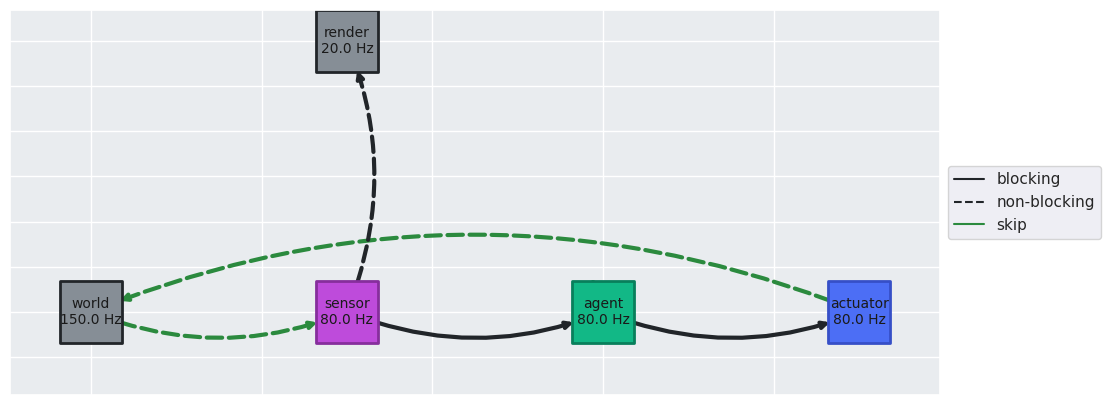

In [5]:
# Plot
fig_gr, _ = exp.show_graph(record_pre.episode[-1])

In [6]:
# Fit delays
data, info, est, dist = exp.make_delay_distributions(record_pre, num_steps=500, num_components=8, step_size=0.05, seed=0)

actuator.input(action) | Time taken: 1.11 seconds.
agent.input(last_action) | Time taken: 0.97 seconds.
agent.input(state) | Time taken: 0.96 seconds.
render.input(sensor) | Time taken: 0.93 seconds.
sensor.input(world) | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.
world.input(actuator) | Time taken: 1.04 seconds.
actuator | Time taken: 1.00 seconds.
agent | Time taken: 1.02 seconds.
render | Time taken: 1.15 seconds.
sensor | Time taken: 1.07 seconds.
world | Skip because close to deterministic | mean(data)=0.0 | std(data)=0.0.


In [7]:
%matplotlib agg

# Plot gmm training
from rex.open_colors import ecolor, fcolor
est_agent = est["step"]["agent"]
fig_agent, ax_agent = plt.subplots()
ax_agent.set(title="GMM fit on computation delay (Agent)", xlabel="delay (s)", ylabel="density")
est_agent.plot_hist(ax=ax_agent, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False)

# Animate
from IPython.display import HTML
ani = est_agent.animate_training(fig=fig_agent, ax=ax_agent, num_frames=50, edgecolor=ecolor.computation, facecolor=fcolor.computation)
HTML(ani.to_html5_video()) 

{'actuator': {'action': None},
 'agent': {'state': None},
 'render': {'sensor': None},
 'sensor': {}}

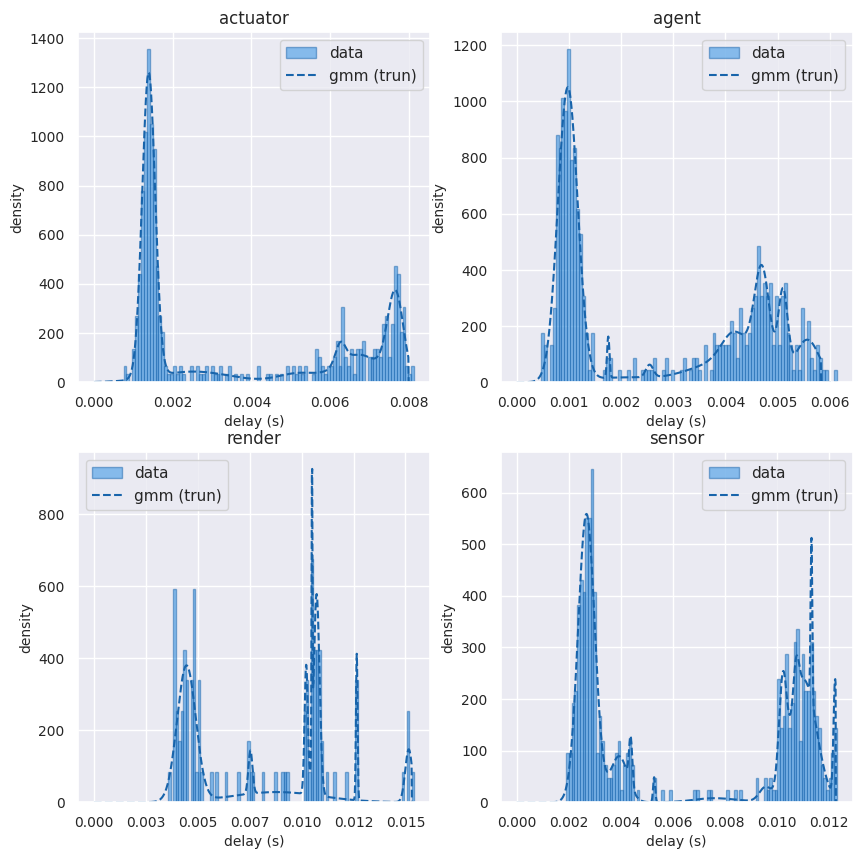

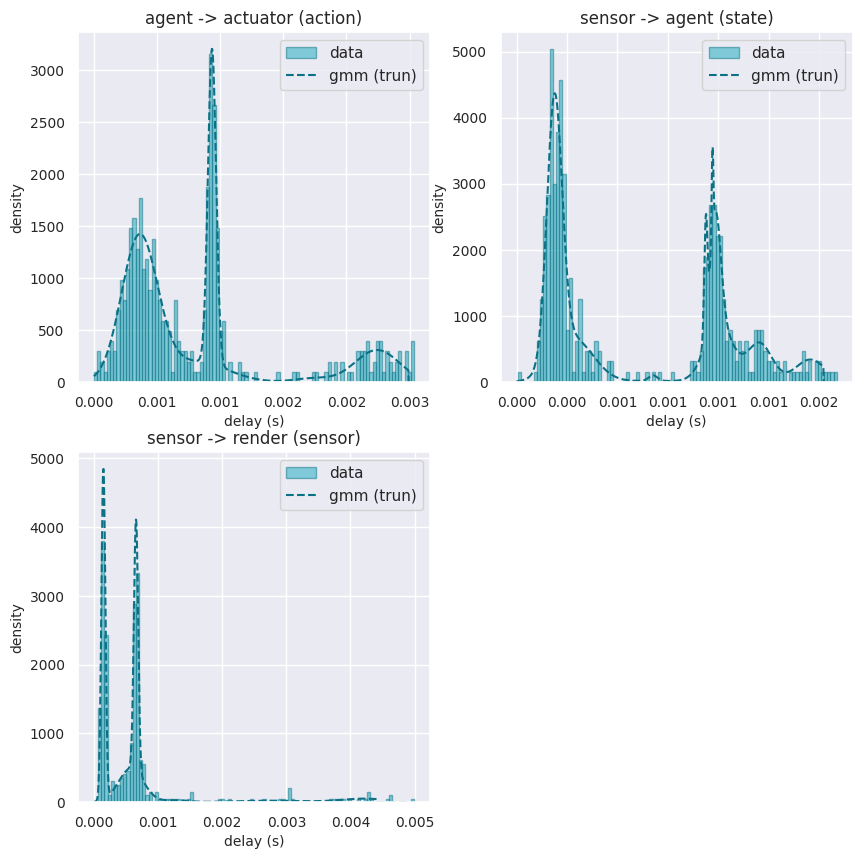

In [8]:
%matplotlib inline
# Pop world from
[_d["inputs"]["agent"].pop("last_action", None) for _d in [data, info, est, dist]]
[_d["inputs"]["sensor"].pop("world", None) for _d in [data, info, est, dist]]
[_d["inputs"].pop("world", None) for _d in [data, info, est, dist]]
[_d["step"].pop("world", None) for _d in [data, info, est, dist]]

# Split
est_inputs, est_step = est["inputs"], est["step"]
data_inputs, data_step = data["inputs"], data["step"]
info_inputs, info_step = info["inputs"], info["step"]
dist_inputs, dist_step = dist["inputs"], dist["step"]

# Plot gmm
from matplotlib.ticker import FormatStrFormatter
import numpy as onp
def plot_gmm(ax, dist, delays, i, edgecolor):
    x = onp.linspace(0, onp.max(delays), 1000)
    y = dist.pdf(x)
    if hasattr(i, "cls"):
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{i.name}")
    else:
        node_info, input_info = i
        ax.plot(x, y, label="gmm (trun)", color=edgecolor, linestyle="--")
        ax.set_title(f"{input_info.output} -> {node_info.name} ({input_info.name})")
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_xlabel('delay (s)', fontsize=10)
    ax.set_ylabel('density', fontsize=10)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.legend()

# Plot distributions
from rex.plot import get_subplots
fig_step, axes_step = get_subplots(est_step, figsize=(10, 10), sharex=False, sharey=False, major="row")
fig_inputs, axes_inputs = get_subplots(est_inputs, figsize=(10, 10), sharex=False, sharey=False, major="row")

# Plot measured delays
from rex.open_colors import ecolor, fcolor
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.computation, facecolor=fcolor.computation, plot_dist=False), axes_step, est_step)
jax.tree_map(lambda ax, e: e.plot_hist(ax=ax, edgecolor=ecolor.communication, facecolor=fcolor.communication, plot_dist=False), axes_inputs, est_inputs)

# Plot gmm
from functools import partial
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.computation), axes_step, dist_step, data_step, info_step)
jax.tree_map(partial(plot_gmm, edgecolor=ecolor.communication), axes_inputs, dist_inputs, data_inputs, info_inputs)

In [9]:
# Trace & compile environment
cenv = exp.make_compiled_env(env, record_pre.episode[-1], max_steps=MAX_STEPS, eval_env=False)

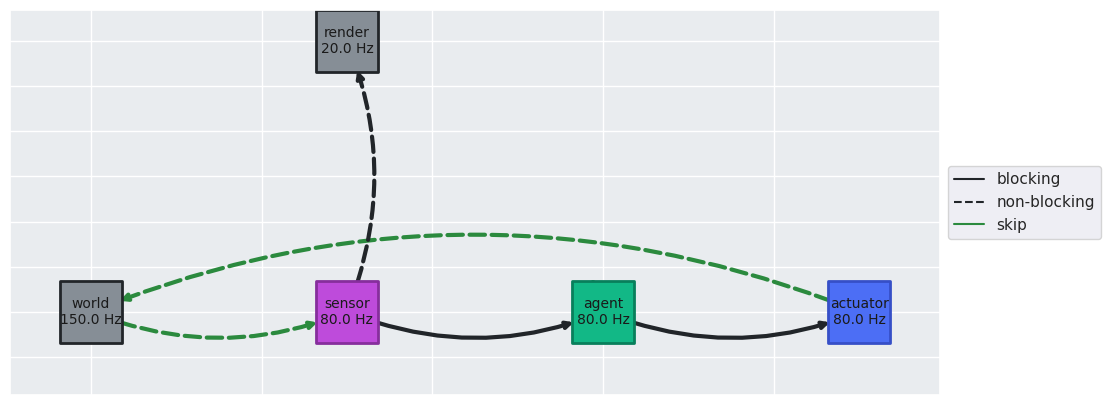

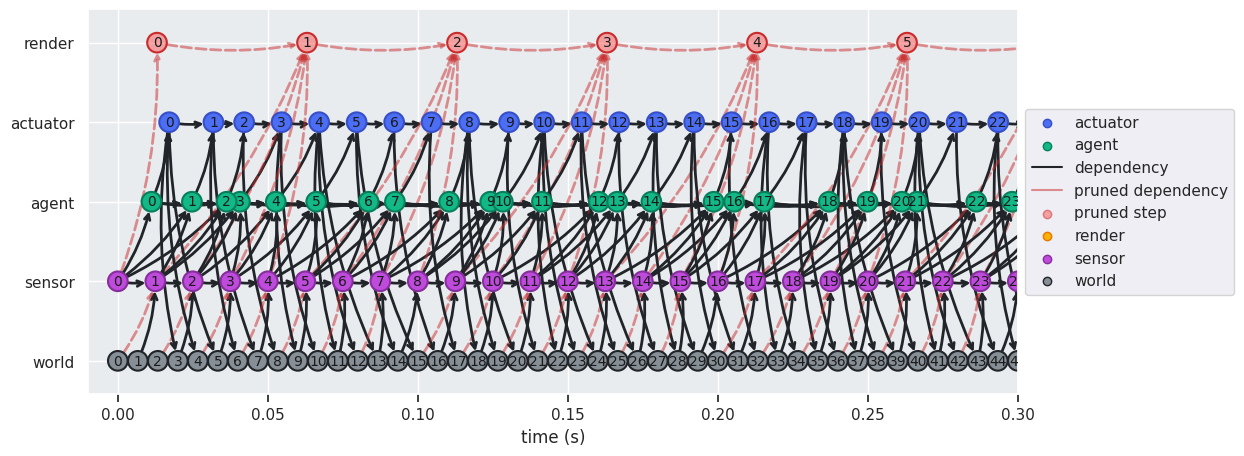

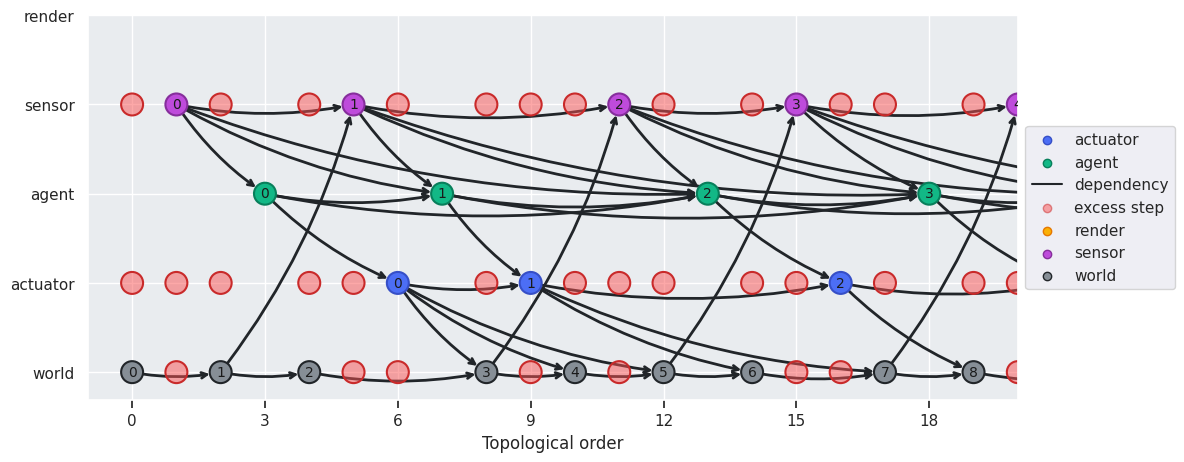

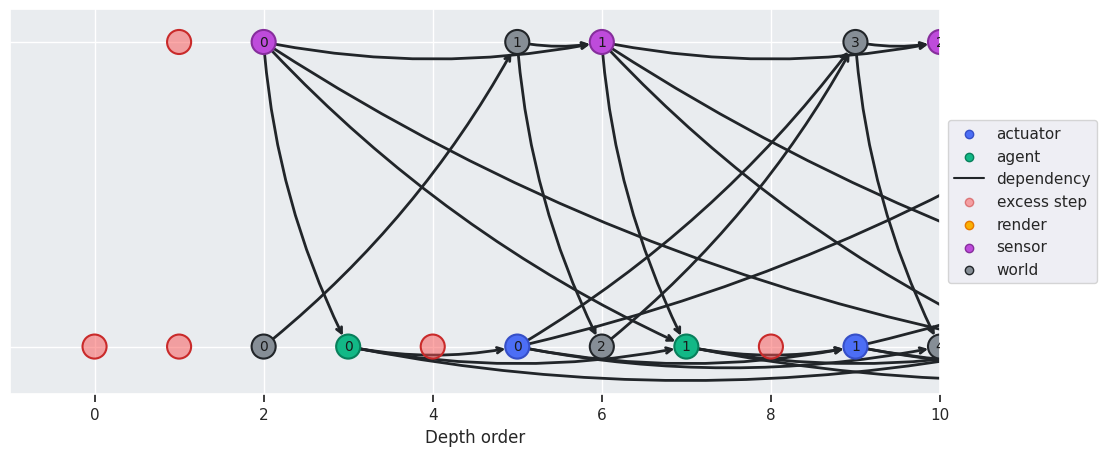

In [10]:
# Create computation graph
from rex.tracer import create_graph
G = create_graph(record_pre.episode[-1])

# Plot
fig_gr, _ = exp.show_graph(record_pre.episode[-1])
fig_cg, _ = exp.show_computation_graph(G, cenv.graph.MCS, "agent", "computation", xmax=0.35)
fig_ct, _ = exp.show_computation_graph(G, cenv.graph.MCS, "agent", "topological", xmax=0.35)
fig_cd, _ = exp.show_computation_graph(G, cenv.graph.MCS, "agent", "depth", xmax=0.35)
# fig_com, _ = exp.show_communication(record_pre.episode[-1])
# fig_grp, _ = exp.show_grouped(record_pre.episode[-1].node[-1], "state")

In [11]:
rw = exp.RolloutWrapper(cenv)

nenvs = 7000
seed = jumpy.random.PRNGKey(0)
rng = jumpy.random.split(seed, num=nenvs)
for i in range(5):
    seed = jumpy.random.PRNGKey(i)
    rng = jumpy.random.split(seed, num=nenvs)
    timer = utils.timer(f"{i=}", log_level=0)
    with timer:
        res = rw.batch_rollout(rng)
    fps = env.max_steps * nenvs / timer.duration
    print(f"[{timer.name}] time={timer.duration} sec | fps={fps:.0f} steps/sec")

[i=0] time=8.541863679885864 sec | fps=327797 steps/sec
[i=1] time=1.4341566562652588 sec | fps=1952367 steps/sec
[i=2] time=1.3806650638580322 sec | fps=2028008 steps/sec
[i=3] time=1.3837065696716309 sec | fps=2023550 steps/sec
[i=4] time=1.4133975505828857 sec | fps=1981042 steps/sec


In [12]:
# Prepare data
data = exp.RecordHelper(record_pre)

# Build estimator
from estimator import build_estimator
record, nodes, excludes_inputs = build_estimator(record_pre, rate=RATE_ESTIMATOR, data=data)

In [14]:
# Trace
from rex.tracer import get_network_record
record_network, MCS, G, G_subgraphs = get_network_record(record.episode, "estimator", split_mode="generational", excludes_inputs=excludes_inputs)

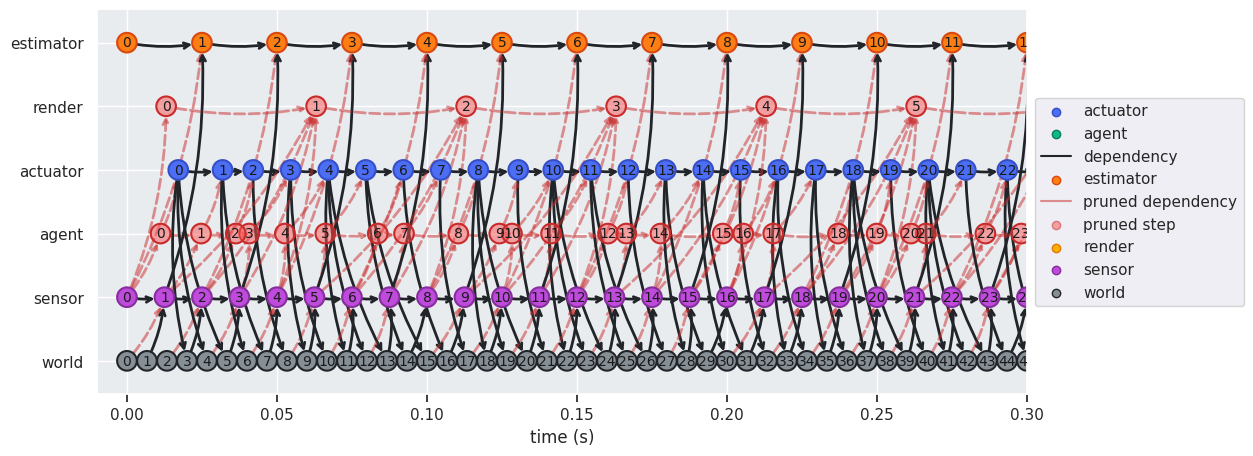

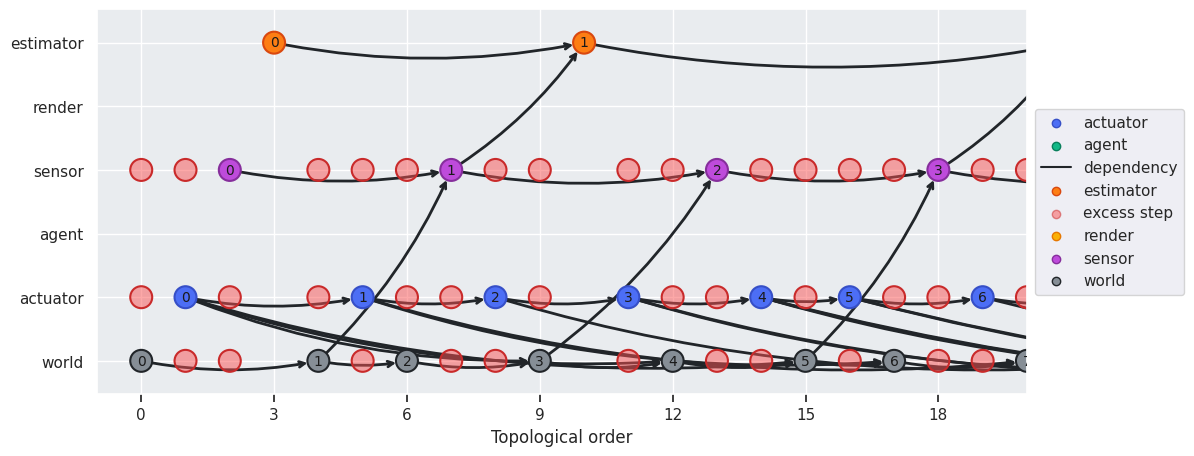

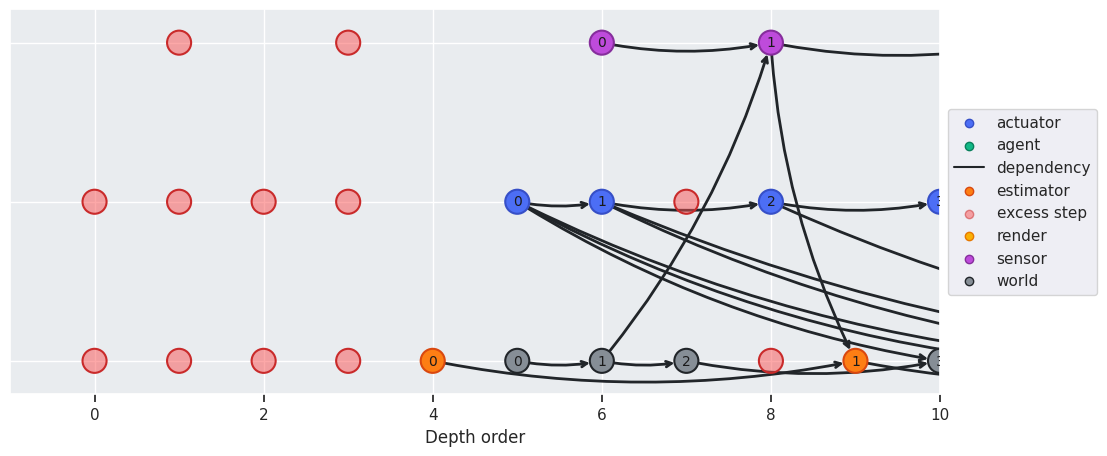

In [15]:
fig_cg, _ = exp.show_computation_graph(G[0], MCS, "estimator", "computation", xmax=0.35)
fig_ct, _ = exp.show_computation_graph(G[0], MCS, "estimator", "topological", xmax=0.35)
fig_cd, _ = exp.show_computation_graph(G[0], MCS, "estimator", "depth", xmax=0.35)

In [16]:
# Add Estimator node to record
import flax.struct as struct
import rex.jumpy as rjp

@struct.dataclass
class Loss:
    loss: jp.float32
    rloss: jp.float32
    dloss: jp.float32


alpha_dloss = nodes["world"].default_state(jumpy.random.PRNGKey(0)).replace(th=jp.float32(0.e0), th2=jp.float32(0.e0), thdot=jp.float32(0.e-2), thdot2=jp.float32(0.e-3))

def loss_fn(graph_state):
    """Get loss."""
    # Calculate reconstruction loss
    rloss_sensor = graph_state.nodes["sensor"].state.cum_loss
    rloss = rloss_sensor.cos_th + rloss_sensor.sin_th + rloss_sensor.sin_th2 + rloss_sensor.cos_th2
    # rloss += 1e-1*rloss_sensor.thdot
    rloss += 1e-3*rloss_sensor.thdot + 1e-3*rloss_sensor.thdot2

    # Calculate transition loss
    fwd_state = graph_state.nodes["world"].state
    # NOTE: mode="clip" disables negative indexing.
    est_state = rjp.tree_take(graph_state.nodes["estimator"].params.world_states, graph_state.step + 1, mode="clip")
    dloss = jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, est_state, fwd_state)
    dloss = jax.tree_util.tree_map(lambda e, a: a*e, dloss, alpha_dloss)
    dloss = jax.tree_util.tree_reduce(lambda acc, l: acc + jp.sum(l), dloss, jp.float32(0.))
    loss = rloss + dloss
    output = Loss(loss=loss, rloss=rloss, dloss=dloss)
    return output

# Compile env
from estimator import EstimatorEnv
from rex.compiled import CompiledGraph

graph = CompiledGraph(nodes, nodes["estimator"], MCS)
cenv = EstimatorEnv(graph, loss_fn=loss_fn)

# Get initial graph_state
from estimator import init_graph_state

init_gs = init_graph_state(cenv, nodes, record_network, MCS, G, G_subgraphs, data)

# Define initial params
p_tree = jax.tree_util.tree_map(lambda x: None, nodes["world"].default_params(jumpy.random.PRNGKey(0)))
# p_world = p_tree.replace(mass=jp.float32(0.3), mass2=jp.float32(0.3), K=jp.float32(1.0), J=jp.float32(0.02))
p_world = jax.tree_util.tree_map(lambda x: x * 1.2, p_tree.replace(# J=jp.float32(0.037),
                                                                   # J2=jp.float32(0.000111608131930852),
                                                                   mass=jp.float32(0.18),
                                                                   mass2=jp.float32(0.0691843934004535),
                                                                   # length=jp.float32(0.1),
                                                                   # length2=jp.float32(0.1),
                                                                   b=jp.float32(0.975872107940422),
                                                                   # b2=jp.float32(1.07098956449896e-05),
                                                                   # c=jp.float32(0.06),
                                                                   # c2=jp.float32(0.0185223578523340),
                                                                   K=jp.float32(1.09724557347983),
                                                                   ))
p_est = init_gs.nodes["estimator"].params
initial_params = {"estimator": p_est, "world": p_world}

# Define prior
def make_prior_fn(guess, multiplier):
    def prior_fn(params):
        loss = jax.tree_util.tree_map(lambda x: None, params)
        if params.get("world", None) is not None:
            wloss = jax.tree_util.tree_map(lambda x, g: 1/(multiplier*(x/g)), params["world"], guess)
            loss["world"] = wloss
        return loss
    return prior_fn

guess = nodes["world"].default_params(jumpy.random.PRNGKey(0))
prior_fn = make_prior_fn(guess, multiplier=10000)

import optax
optimizer = optax.adam(learning_rate=5e-2)

# Define callbacks
from estimator.callback import LogCallback, StateFitCallback, ParamFitCallback
targets = nodes["world"].default_params(jumpy.random.PRNGKey(0))
callbacks = {"log": LogCallback(visualize=False),
             "state_fit": StateFitCallback(visualize=False),
             "param_fit": ParamFitCallback(targets=targets, visualize=False)}

# Optimize
from estimator import fit
metrics, opt_params, opt_state, opt_gs = fit(cenv, initial_params, optimizer, init_gs,
                                             # num_steps=10, num_batches=50, lr=1e-2 works, 1e-3 thdot.
                                             prior_fn=prior_fn, num_batches=50, num_steps=5, num_training_steps=10_000,
                                             num_training_steps_per_epoch=200, callbacks=callbacks)
# Print results
print(jax.tree_util.tree_map(lambda x, y: jp.stack([x, y], axis=0), opt_params["world"], nodes["world"].default_params(jumpy.random.PRNGKey(0))))

epoch 0 | step 200 | 3.15 steps/sec | min(loss)= 0.451 | loss: 25.596 +/- 34.635 | max(loss)= 110.206
epoch 1 | step 400 | 32.56 steps/sec | min(loss)= 0.126 | loss: 0.595 +/- 0.315 | max(loss)= 1.503
epoch 2 | step 600 | 35.27 steps/sec | min(loss)= 0.108 | loss: 0.437 +/- 0.280 | max(loss)= 1.257
epoch 3 | step 800 | 38.35 steps/sec | min(loss)= 0.064 | loss: 0.430 +/- 0.291 | max(loss)= 1.265
epoch 4 | step 1000 | 39.58 steps/sec | min(loss)= 0.052 | loss: 0.401 +/- 0.262 | max(loss)= 1.203
epoch 5 | step 1200 | 36.06 steps/sec | min(loss)= 0.049 | loss: 0.400 +/- 0.286 | max(loss)= 1.246
epoch 6 | step 1400 | 36.98 steps/sec | min(loss)= 0.043 | loss: 0.400 +/- 0.274 | max(loss)= 1.236
epoch 7 | step 1600 | 37.36 steps/sec | min(loss)= 0.023 | loss: 0.296 +/- 0.246 | max(loss)= 1.142
epoch 8 | step 1800 | 35.29 steps/sec | min(loss)= 0.027 | loss: 0.293 +/- 0.235 | max(loss)= 0.937
epoch 9 | step 2000 | 36.07 steps/sec | min(loss)= 0.024 | loss: 0.310 +/- 0.234 | max(loss)= 0.893
e

In [17]:
%matplotlib agg

# Create animation
from IPython.display import HTML
ani_duration = 15.0
num_frames = len(callbacks["log"]._frames)
interval = int(1e3*ani_duration / num_frames)

# Loss animation
ani = callbacks["log"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [18]:
%matplotlib agg

# State fitting animation
ani = callbacks["state_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())

In [19]:
%matplotlib agg
# Parameter fitting animation
ani = callbacks["param_fit"].get_animation(interval=interval)
HTML(ani.to_html5_video())